#Wine Quality Dataset for classification

In [1]:
#Install dependencies
!pip install fastai
!pip install nbdev
!pip install ucimlrepo

#Import libraries
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import fastai
from fastai.tabular.all import *
import torch
import torch.nn.functional as F
import torch.nn as nn
import pickle
import copy
import time
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler

#Connect to drive
#from google.colab import drive
#drive.mount('/content/drive')



#Convert and import personalised library
#!jupyter nbconvert --to python /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.ipynb --output utilsTFG.py
#!cp /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.py .
import sys
sys.path.append('/notebooks/utilstfg.py')
import utilstfg as utilsTFG


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.5/234.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.0/80.0 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.4/67.4 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.0/79.0 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: certifi
    Found existing installation: certifi 2020.6.20
    Uninstalling certifi-2020.6.20:
      Successfully uninstalled certifi-2020.6.20


In [2]:
#The dataset is so imbalanced that we need to avoid this warning because its too annoying.
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Set seed for fastai
fastai.torch_core.set_seed(42)

# Set seed for torch
torch.manual_seed(42)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(42)

# Set seed for numpy
np.random.seed(42)

cuda


### Datos y modelos

In [4]:
dataset='wqc'
plot_dataset='WQC'

#Download the dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)

X = wine_quality.data.features
y = wine_quality.data.targets

#Show the data
print(X.head())



# Define the categorical and continuous variables
cat_names = []
cont_names = list(X.columns)
dep_var = 'quality'


df=pd.concat([X, y], axis=1)

# metadata
print(wine_quality.metadata)

# variable information
print(wine_quality.variables)


   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  
0      9.4  
1      9.8  
2      9.8  
3      9.8  
4      9.4  
{'uci_id

In [5]:
#Show if there is missing data
missing_values = df.isna().sum()
print(missing_values)

#Handle the missing data, filling with the mean
#mis_col = []
#df[mis_col] = df[mis_col].fillna(df.mean())


fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


quality                 1.000000
alcohol                 0.444319
density                 0.305858
volatile_acidity        0.265699
chlorides               0.200666
citric_acid             0.085532
fixed_acidity           0.076743
free_sulfur_dioxide     0.055463
total_sulfur_dioxide    0.041385
sulphates               0.038485
residual_sugar          0.036980
pH                      0.019506
dtype: float64


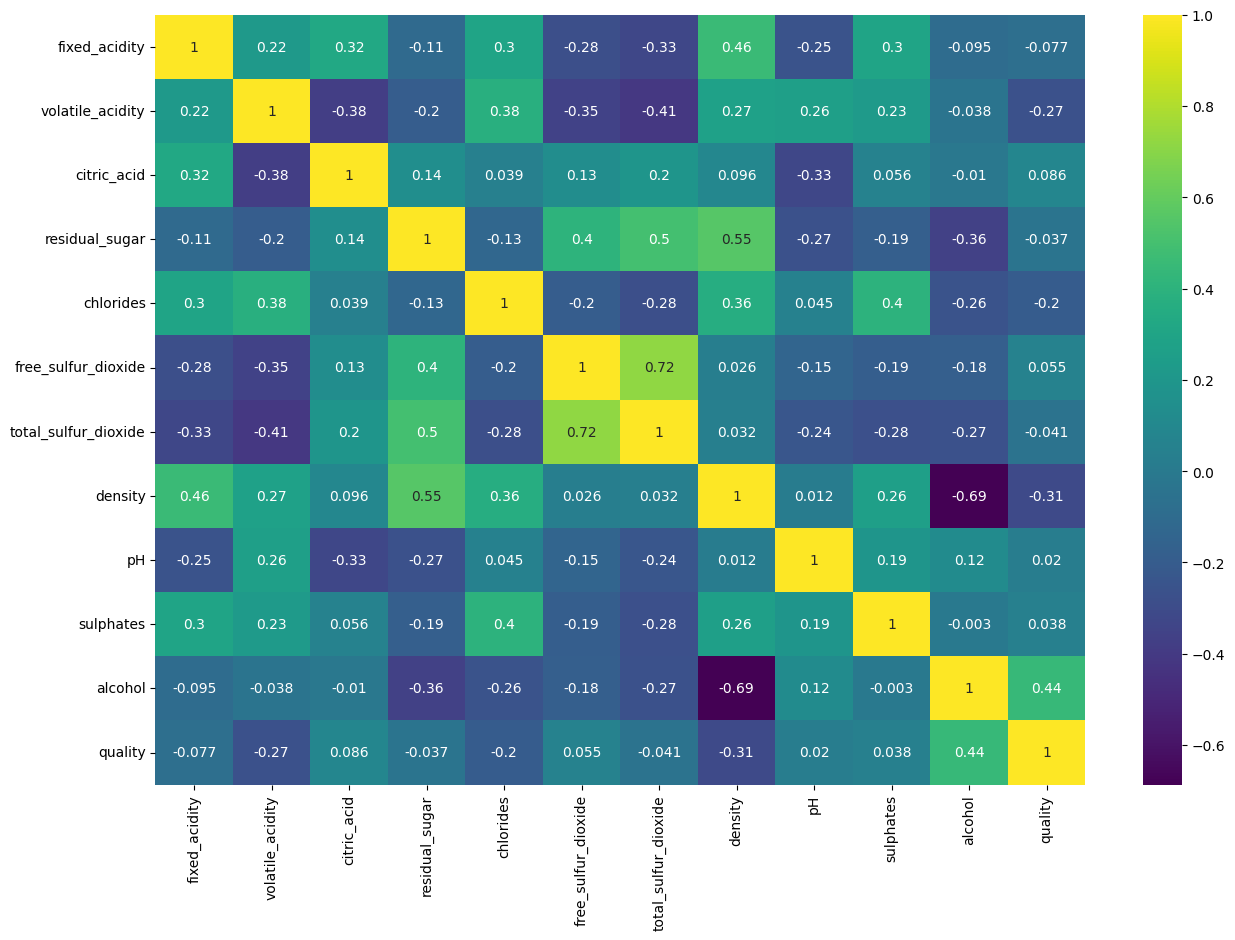

In [6]:
##Preprocessing

#Correlation of all features with the target
corr_mat = df.corr()[dep_var]
target_corr = np.abs(df.corrwith(df[dep_var]))
print(target_corr.sort_values(ascending=False))

#Correlation of features with each other
corr_matrix = df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix,cmap="viridis", annot=True)
plt.show()


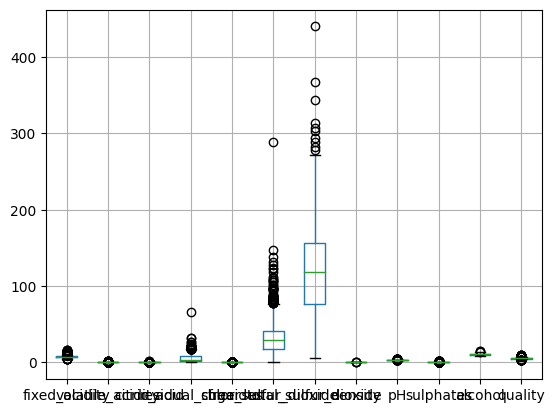

In [7]:
#Boxplot to see the range of feature values
df.boxplot()
plt.show()

In [8]:
#Drop features with low correlation with the target
df.drop(['pH', 'residual_sugar', 'sulphates', 'total_sulfur_dioxide'], axis=1, inplace=True)
cont_names.remove('pH')
cont_names.remove('residual_sugar')
cont_names.remove('sulphates')
cont_names.remove('total_sulfur_dioxide')

In [9]:
#Drop features with too much correlation between them

corr_matrix = df.corr()
threshold = 0.9

# Find pairs of features with correlation above the threshold
high_corr_pairs = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns if i != j and corr_matrix.loc[i, j] > threshold]

to_drop = set()


for i, j in high_corr_pairs:
    if i not in to_drop and j not in to_drop:
        # Add one of the features to the drop list
        to_drop.add(j)

# Drop the identified features from the DataFrame and the features list
df.drop(columns=to_drop, inplace=True)
cont_names = [col for col in cont_names if col not in to_drop]

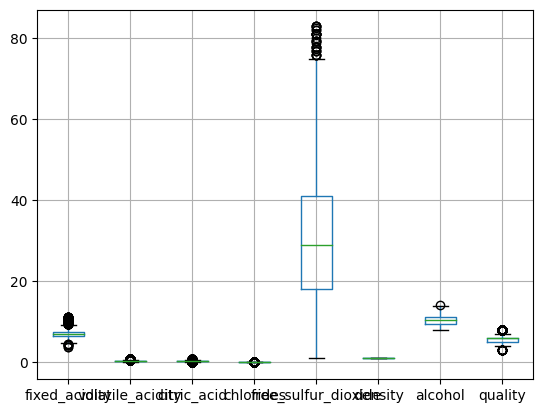

In [10]:
#Remove outliers
df_c = df.loc[(stats.zscore(df) < 3).all(axis=1)]
df_c.boxplot()
plt.show()

In [11]:
# Split indices for training, validation, and test sets
df_c = df_c.reset_index(drop=True)
train_val_split = RandomSplitter(valid_pct=0.3)(range_of(df_c))  # 70% for training/validation, 30% for testing
train_idx, val_test_idx = train_val_split

# Now split the validation/test set into validation and test sets (~20% test ~10% validation)
val_test_split = RandomSplitter(valid_pct=0.7)(val_test_idx)
val_idx, test_idx = val_test_split

# Combine all indices for the splits
splits = (train_idx, val_idx)

#Normalize
scaler = StandardScaler()
for feat in cont_names:
    df_c.loc[train_idx,feat] = scaler.fit_transform(df_c.loc[train_idx,[feat]])
    df_c.loc[val_idx,feat] = scaler.transform(df_c.loc[val_idx,[feat]])
    df_c.loc[test_idx,feat] = scaler.transform(df_c.loc[test_idx,[feat]])


# Create TabularPandas for training and validation
to = TabularPandas(
    df_c,
    procs=[Categorify],
    cat_names=cat_names,
    cont_names=cont_names,
    y_names=dep_var,
    splits=splits
)


# Create DataLoaders for training and validation
dls = to.dataloaders(bs=64, shuffle=True)

test_to = TabularPandas(
    df_c.iloc[test_idx],  # Select only the test data
    procs=[Categorify],
    cat_names=cat_names,
    cont_names=cont_names,
    y_names=dep_var
)

# Create a DataLoader for the test set. Dont shuffle to get a more objective value across computations
test_dl = test_to.dataloaders(bs=64, shuffle=False)
dls.to(device)
test_dl.to(device)

In [12]:
#Initialise arrays for the loops
layers = [[64], [64, 64], [ 64, 128, 256, 128, 64], [32, 64, 128, 256, 512, 1024, 512, 256, 128, 64, 32] ]
n_layers=[1,2,5,11]
optims = ['NAG', 'RMSProp', 'ADAM']
names_layer=['1 layer', '2 layers', '5 layers', '11 layers']
algs = ['SHADE', 'SHADE-ILS', 'SHADE-GD', 'SHADE-ILS-GD']
metric = ['BalAcc']
init_weights = {}
for layer in n_layers:
  init_weights[layer] = {}

In [13]:
#For each number of layers initialise the model with the same parameters.
for layer in layers:
  learn = tabular_learner(dls, layers=layer, n_out=10, metrics=utilsTFG.balanced_accuracy_func, loss_func=CrossEntropyLossFlat())
  learn.model.apply(utilsTFG.init_weights_glorot)
  learn.to(device)
  init_weights[len(layer)] = utilsTFG.get_params_from_model(learn.model)

  print(learn.summary())

TabularModel (Input shape: 64 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 7              
BatchNorm1d                               14         True      
____________________________________________________________________________
                     64 x 64             
Linear                                    448        True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     64 x 10             
Linear                                    650        True      
____________________________________________________________________________

Total params: 1,240
Total trainable params: 1,240
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7f77f63af240>
Loss function: FlattenedLoss of CrossEntropyLoss()

Callbacks:
  - TrainEvalCallback
  - Cas

TabularModel (Input shape: 64 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 7              
BatchNorm1d                               14         True      
____________________________________________________________________________
                     64 x 64             
Linear                                    448        True      
ReLU                                                           
BatchNorm1d                               128        True      
Linear                                    4096       True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     64 x 10             
Linear                                    650        True      
____________________________________________________________________________

Total params: 5,464
Total train

TabularModel (Input shape: 64 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 7              
BatchNorm1d                               14         True      
____________________________________________________________________________
                     64 x 64             
Linear                                    448        True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     64 x 128            
Linear                                    8192       True      
ReLU                                                           
BatchNorm1d                               256        True      
____________________________________________________________________________
                     64 x 256            
Linear                                    32768      T

TabularModel (Input shape: 64 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 7              
BatchNorm1d                               14         True      
____________________________________________________________________________
                     64 x 32             
Linear                                    224        True      
ReLU                                                           
BatchNorm1d                               64         True      
____________________________________________________________________________
                     64 x 64             
Linear                                    2048       True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     64 x 128            
Linear                                    8192       T

## Gradient Descent

In [14]:
# Define the optimizers
NAG = partial(OptimWrapper, opt=torch.optim.SGD, momentum=0.9, nesterov=True)
RMSProp = partial(OptimWrapper, opt=torch.optim.RMSprop)
ADAM = partial(OptimWrapper, opt=torch.optim.Adam)
optims2 = [NAG, RMSProp, ADAM]

# Initialize the learners dictionary
learners = {}
time_gd = {}
epochs=20

# Iterate over the optimizers and layers to create learners
for opt, opt2 in zip(optims, optims2):
    learners[opt] = {}  # Initialize the dictionary for this optimizer
    time_gd[opt] = {}
    for layer in layers:
        learners[opt][len(layer)] = tabular_learner(dls=dls, layers=layer, n_out=10, loss_func=CrossEntropyLossFlat(), metrics=utilsTFG.balanced_accuracy_func, opt_func=opt2, cbs=[SaveModelCallback()])
        learners[opt][len(layer)].to(device)
        learners[opt][len(layer)].model.to(device)
        utilsTFG.set_params_to_model(init_weights[len(layer)], learners[opt][len(layer)].model)


In [15]:
#To check if the models have the same initial parameters
for layer in n_layers:
  if utilsTFG.compare_models(learners['NAG'][layer], learners['RMSProp'][layer]) and utilsTFG.compare_models(learners['NAG'][layer], learners['ADAM'][layer]) and utilsTFG.compare_models(learners['ADAM'][layer], learners['RMSProp'][layer]):
    print(f"Mismos parámetros en capa {layer}.")
  else:
    print("Distintos parámetros.")

Mismos parámetros en capa 1.
Mismos parámetros en capa 2.
Mismos parámetros en capa 5.
Mismos parámetros en capa 11.


### Nesterov

Better model found at epoch 0 with valid_loss value: 2.2924814224243164.
Better model found at epoch 1 with valid_loss value: 1.738207221031189.
Better model found at epoch 2 with valid_loss value: 1.3312878608703613.
Better model found at epoch 3 with valid_loss value: 1.1815613508224487.
Better model found at epoch 4 with valid_loss value: 1.1372722387313843.
Better model found at epoch 5 with valid_loss value: 1.1052311658859253.
Better model found at epoch 6 with valid_loss value: 1.1032893657684326.
Better model found at epoch 7 with valid_loss value: 1.0876303911209106.
Better model found at epoch 8 with valid_loss value: 1.0859233140945435.
Better model found at epoch 9 with valid_loss value: 1.0855698585510254.
Better model found at epoch 10 with valid_loss value: 1.0646376609802246.
Better model found at epoch 11 with valid_loss value: 1.0554267168045044.
Better model found at epoch 14 with valid_loss value: 1.0466043949127197.
Better model found at epoch 18 with valid_loss va

Better model found at epoch 0 with valid_loss value: 2.588813543319702.
Better model found at epoch 1 with valid_loss value: 1.8316963911056519.
Better model found at epoch 2 with valid_loss value: 1.3959401845932007.
Better model found at epoch 3 with valid_loss value: 1.1956067085266113.
Better model found at epoch 4 with valid_loss value: 1.1258938312530518.
Better model found at epoch 5 with valid_loss value: 1.0942550897598267.
Better model found at epoch 7 with valid_loss value: 1.0721369981765747.
Better model found at epoch 8 with valid_loss value: 1.053892970085144.
Better model found at epoch 9 with valid_loss value: 1.0372099876403809.
Better model found at epoch 10 with valid_loss value: 1.0362093448638916.
Better model found at epoch 11 with valid_loss value: 1.027931809425354.
Better model found at epoch 13 with valid_loss value: 1.0243487358093262.
Better model found at epoch 14 with valid_loss value: 1.0087037086486816.
Better model found at epoch 18 with valid_loss val

Better model found at epoch 0 with valid_loss value: 2.380764961242676.
Better model found at epoch 1 with valid_loss value: 1.9052822589874268.
Better model found at epoch 2 with valid_loss value: 1.5028389692306519.
Better model found at epoch 3 with valid_loss value: 1.2195385694503784.
Better model found at epoch 4 with valid_loss value: 1.1520650386810303.
Better model found at epoch 5 with valid_loss value: 1.0543097257614136.
Better model found at epoch 7 with valid_loss value: 1.0488691329956055.
Better model found at epoch 8 with valid_loss value: 0.9964021444320679.
Better model found at epoch 9 with valid_loss value: 0.9918986558914185.
Better model found at epoch 11 with valid_loss value: 0.9744879603385925.
Better model found at epoch 13 with valid_loss value: 0.9611316919326782.
Better model found at epoch 14 with valid_loss value: 0.9252700805664062.
Better model found at epoch 17 with valid_loss value: 0.9172633290290833.


Better model found at epoch 0 with valid_loss value: 2.396502733230591.
Better model found at epoch 1 with valid_loss value: 1.6648249626159668.
Better model found at epoch 2 with valid_loss value: 1.289402723312378.
Better model found at epoch 3 with valid_loss value: 1.1203503608703613.
Better model found at epoch 4 with valid_loss value: 1.0597959756851196.
Better model found at epoch 5 with valid_loss value: 1.0054508447647095.
Better model found at epoch 6 with valid_loss value: 0.9996774196624756.
Better model found at epoch 7 with valid_loss value: 0.9852609038352966.
Better model found at epoch 8 with valid_loss value: 0.9517940878868103.
Better model found at epoch 12 with valid_loss value: 0.9446977972984314.
Better model found at epoch 15 with valid_loss value: 0.9178507328033447.
Better model found at epoch 18 with valid_loss value: 0.9174720644950867.


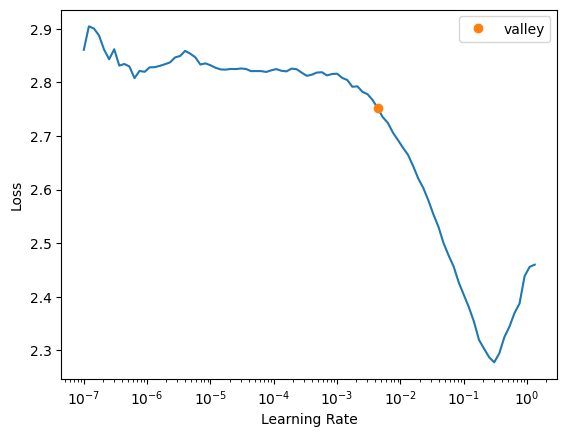

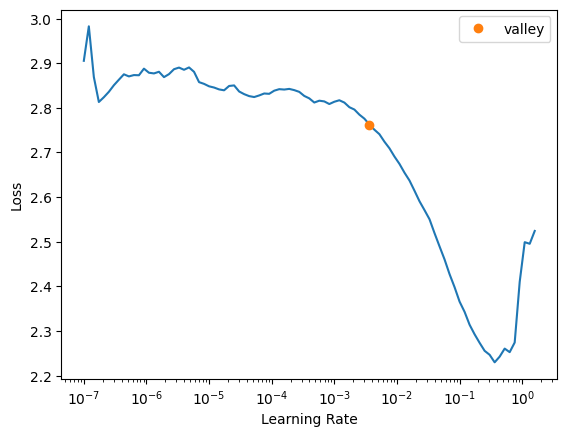

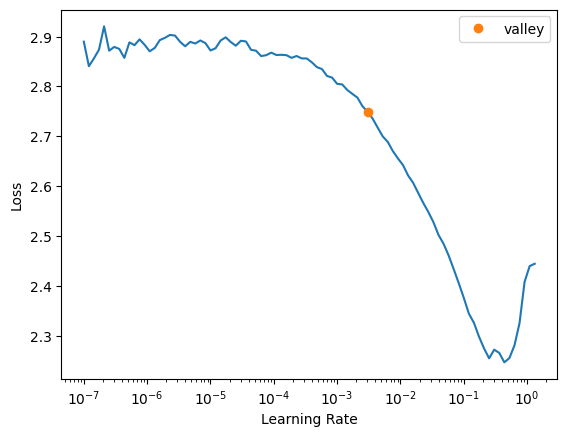

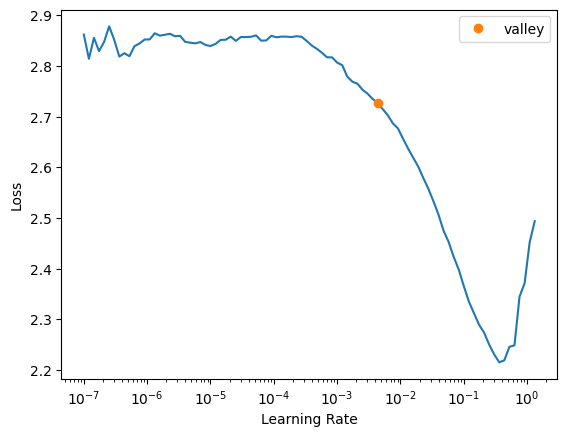

In [16]:
#Run the training and measure the time for each layer
for layer, learner in learners['NAG'].items():
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['NAG'][layer] = end-start



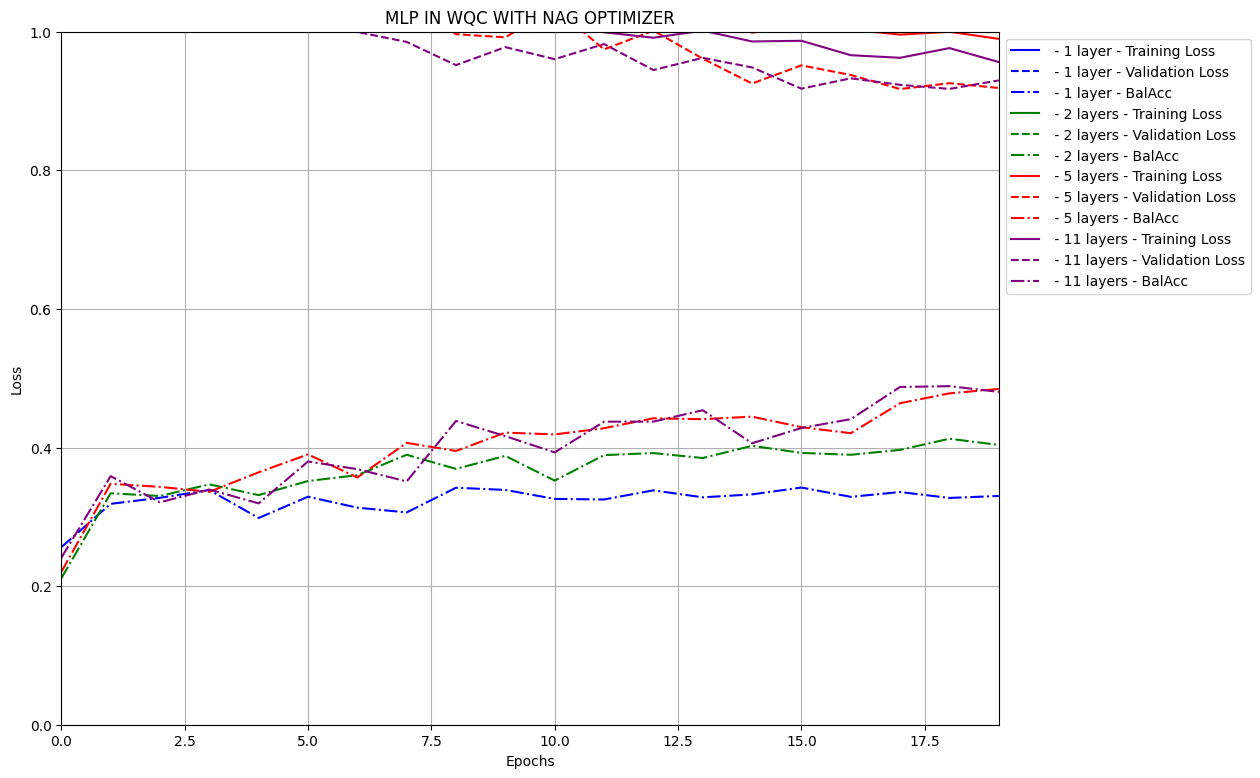

In [17]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['NAG'].values(), title=f'MLP IN {plot_dataset} WITH NAG OPTIMIZER', names=names_layer, metric=metric)

### RMSProp

Better model found at epoch 0 with valid_loss value: 1.216920256614685.
Better model found at epoch 1 with valid_loss value: 1.104411005973816.
Better model found at epoch 3 with valid_loss value: 1.0438337326049805.
Better model found at epoch 5 with valid_loss value: 1.0197614431381226.


Better model found at epoch 0 with valid_loss value: 1.1851723194122314.
Better model found at epoch 1 with valid_loss value: 1.086421251296997.
Better model found at epoch 3 with valid_loss value: 1.0502004623413086.
Better model found at epoch 6 with valid_loss value: 1.0423163175582886.
Better model found at epoch 7 with valid_loss value: 1.0164192914962769.


Better model found at epoch 0 with valid_loss value: 1.219278335571289.
Better model found at epoch 1 with valid_loss value: 1.118830919265747.
Better model found at epoch 2 with valid_loss value: 0.9997008442878723.
Better model found at epoch 12 with valid_loss value: 0.9843223094940186.


Better model found at epoch 0 with valid_loss value: 1.6090911626815796.
Better model found at epoch 1 with valid_loss value: 1.0613391399383545.
Better model found at epoch 3 with valid_loss value: 1.00890052318573.
Better model found at epoch 10 with valid_loss value: 1.0021085739135742.
Better model found at epoch 16 with valid_loss value: 0.992449939250946.
Better model found at epoch 18 with valid_loss value: 0.9770302772521973.


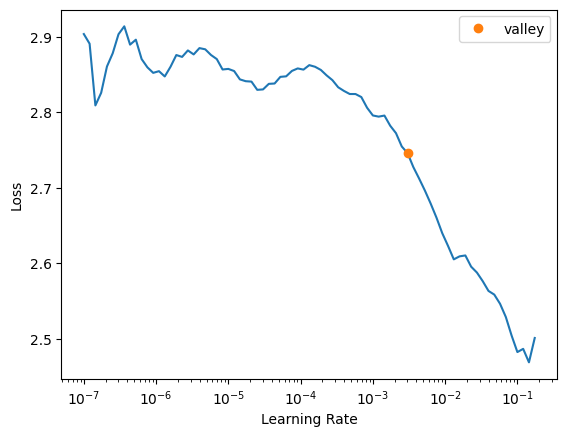

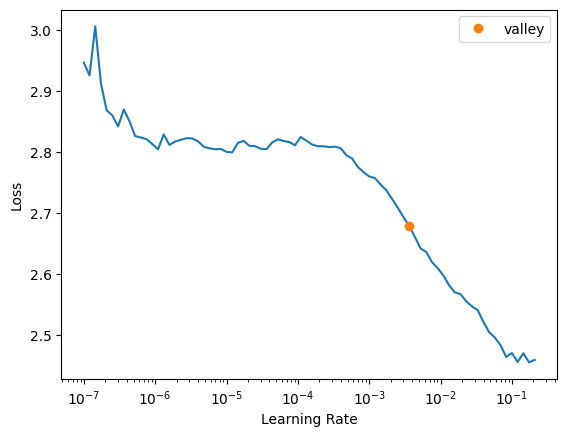

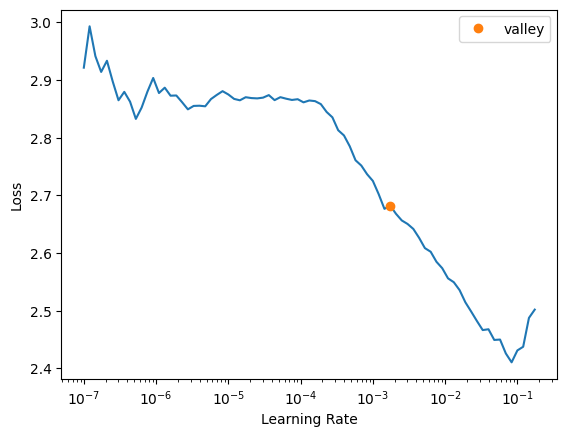

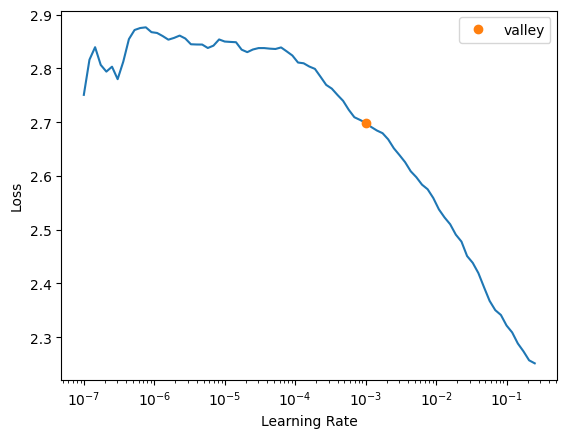

In [18]:
#Run the training and measure the time for each layer
for layer, learner in learners['RMSProp'].items():
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['RMSProp'][layer] = end-start


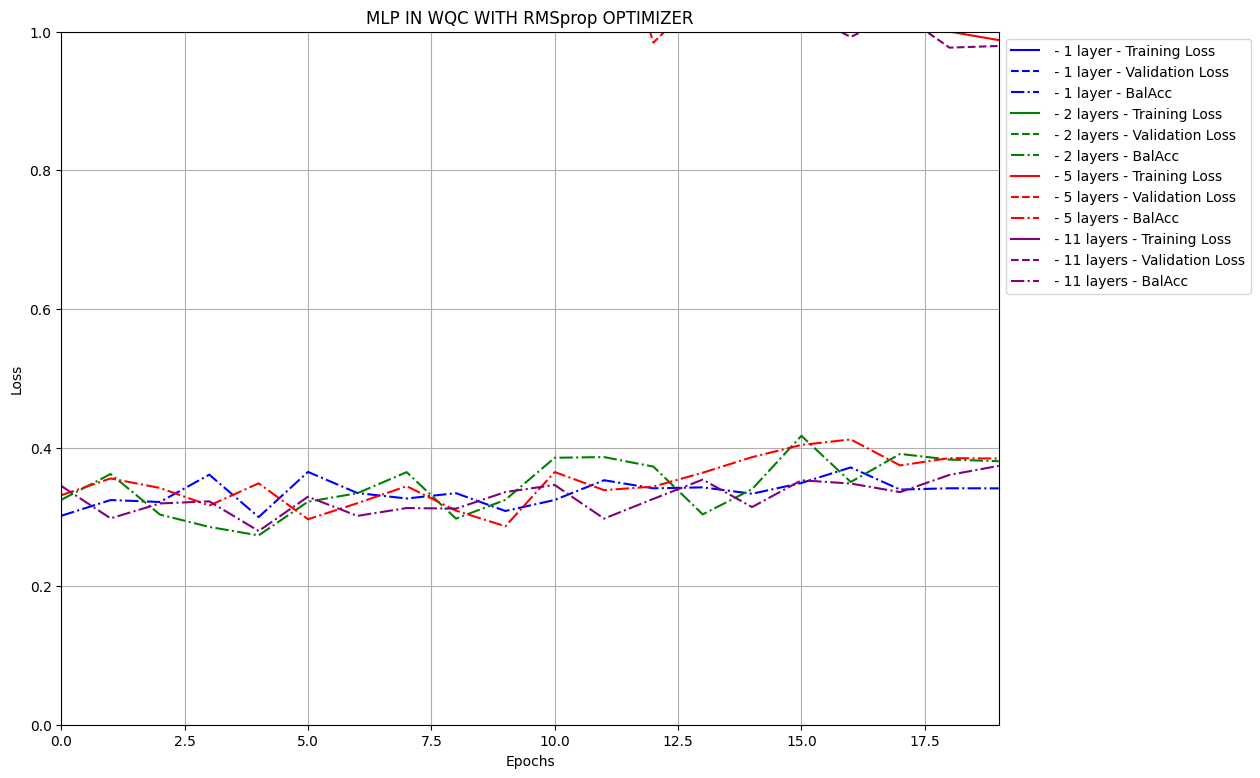

In [19]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['RMSProp'].values(), title=f'MLP IN {plot_dataset} WITH RMSprop OPTIMIZER', names=names_layer, metric=metric)

### Adam

Better model found at epoch 0 with valid_loss value: 2.4549107551574707.
Better model found at epoch 1 with valid_loss value: 1.9912822246551514.
Better model found at epoch 2 with valid_loss value: 1.3934242725372314.
Better model found at epoch 3 with valid_loss value: 1.132331371307373.
Better model found at epoch 4 with valid_loss value: 1.0738186836242676.
Better model found at epoch 6 with valid_loss value: 1.052082896232605.
Better model found at epoch 7 with valid_loss value: 1.043733835220337.
Better model found at epoch 8 with valid_loss value: 1.0286660194396973.
Better model found at epoch 14 with valid_loss value: 1.014770269393921.
Better model found at epoch 18 with valid_loss value: 1.013386607170105.


Better model found at epoch 0 with valid_loss value: 2.8279852867126465.
Better model found at epoch 1 with valid_loss value: 2.3858394622802734.
Better model found at epoch 2 with valid_loss value: 1.8982453346252441.
Better model found at epoch 3 with valid_loss value: 1.5067092180252075.
Better model found at epoch 4 with valid_loss value: 1.2019832134246826.
Better model found at epoch 5 with valid_loss value: 1.1165157556533813.
Better model found at epoch 6 with valid_loss value: 1.053844928741455.
Better model found at epoch 7 with valid_loss value: 1.0376548767089844.
Better model found at epoch 8 with valid_loss value: 1.0350300073623657.
Better model found at epoch 9 with valid_loss value: 1.0012505054473877.
Better model found at epoch 11 with valid_loss value: 0.9878005385398865.
Better model found at epoch 15 with valid_loss value: 0.9814285635948181.


Better model found at epoch 0 with valid_loss value: 2.2963316440582275.
Better model found at epoch 1 with valid_loss value: 2.114504814147949.
Better model found at epoch 2 with valid_loss value: 2.0284531116485596.
Better model found at epoch 3 with valid_loss value: 1.5440560579299927.
Better model found at epoch 4 with valid_loss value: 1.287145733833313.
Better model found at epoch 5 with valid_loss value: 1.0869919061660767.
Better model found at epoch 6 with valid_loss value: 1.0332947969436646.
Better model found at epoch 8 with valid_loss value: 0.9897499680519104.
Better model found at epoch 9 with valid_loss value: 0.9788936972618103.
Better model found at epoch 13 with valid_loss value: 0.9540297389030457.
Better model found at epoch 15 with valid_loss value: 0.9298804402351379.
Better model found at epoch 16 with valid_loss value: 0.9218271970748901.


Better model found at epoch 0 with valid_loss value: 2.3942160606384277.
Better model found at epoch 1 with valid_loss value: 2.03645920753479.
Better model found at epoch 2 with valid_loss value: 1.7805798053741455.
Better model found at epoch 3 with valid_loss value: 1.5913575887680054.
Better model found at epoch 4 with valid_loss value: 1.256595492362976.
Better model found at epoch 5 with valid_loss value: 1.084789752960205.
Better model found at epoch 6 with valid_loss value: 1.0540584325790405.
Better model found at epoch 7 with valid_loss value: 0.9853848814964294.
Better model found at epoch 8 with valid_loss value: 0.9668654799461365.
Better model found at epoch 11 with valid_loss value: 0.952282726764679.
Better model found at epoch 13 with valid_loss value: 0.9358551502227783.
Better model found at epoch 14 with valid_loss value: 0.9142990112304688.
Better model found at epoch 16 with valid_loss value: 0.8876282572746277.
Better model found at epoch 17 with valid_loss value

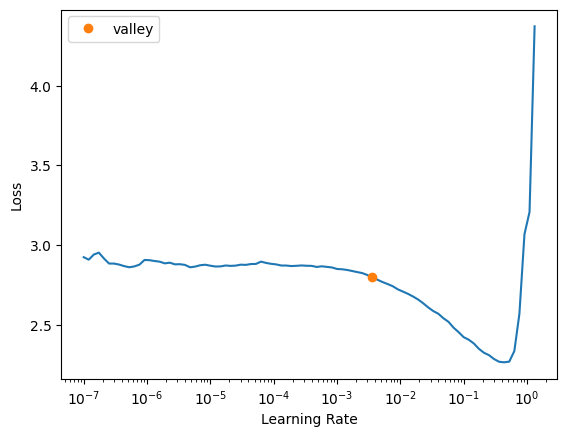

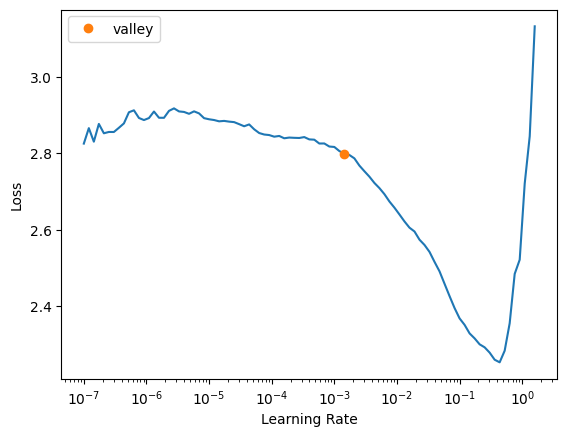

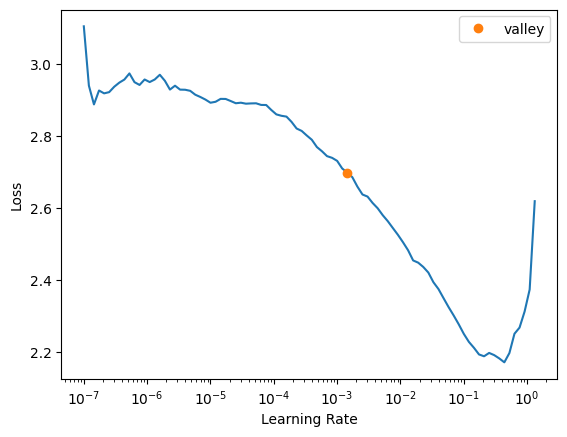

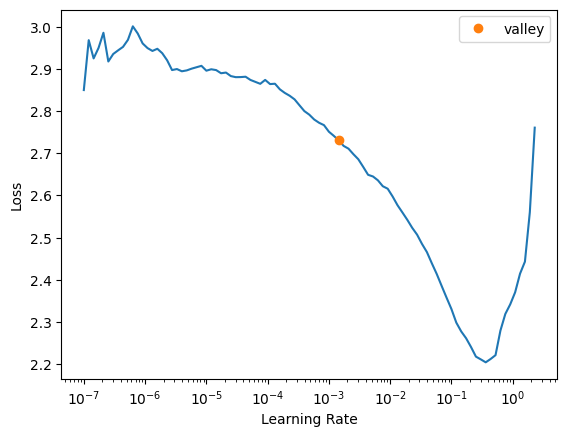

In [20]:
#Run the training and measure the time for each layer
for layer, learner in learners['ADAM'].items():
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['ADAM'][layer] = end-start


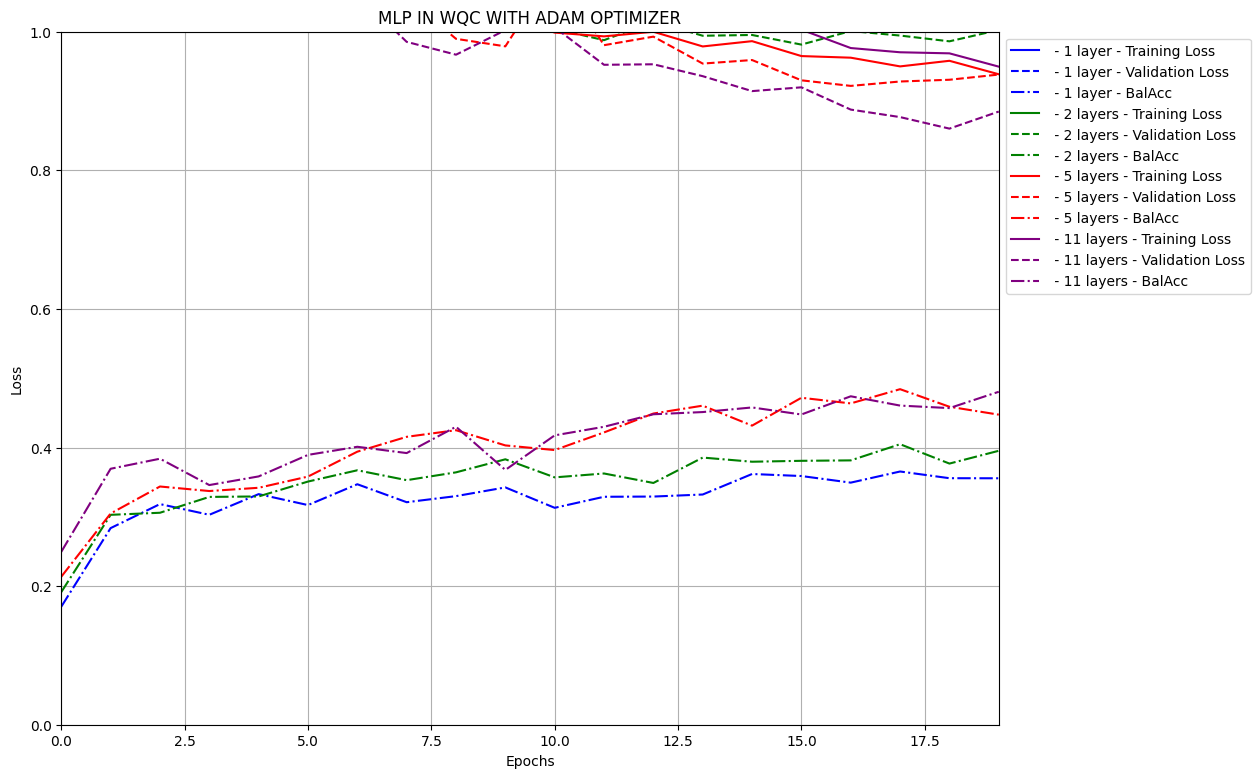

In [21]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['ADAM'].values(), title=f'MLP IN {plot_dataset} WITH ADAM OPTIMIZER', names=names_layer, metric=metric)

### Save or Load models

In [22]:
#Save learner with their losses and metrics
for optim in optims:
  for layer in n_layers:
    file_path = f'/notebooks/saved_models/learner_{dataset}_{layer}_{optim}.pkl'
    with open(file_path, 'wb') as f:
        pickle.dump({'learner': learners[optim][layer], 'recorder_values': learners[optim][layer].recorder.values}, f)


In [23]:
#Load learner with their losses and metrics
for optim in optims:
  for layer in n_layers:
    file_path = f'/notebooks/saved_models/learner_{dataset}_{layer}_{optim}.pkl'
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    learners[optim][layer], learners[optim][layer].recorder.values = data['learner'], data['recorder_values']

### Comparative per layers

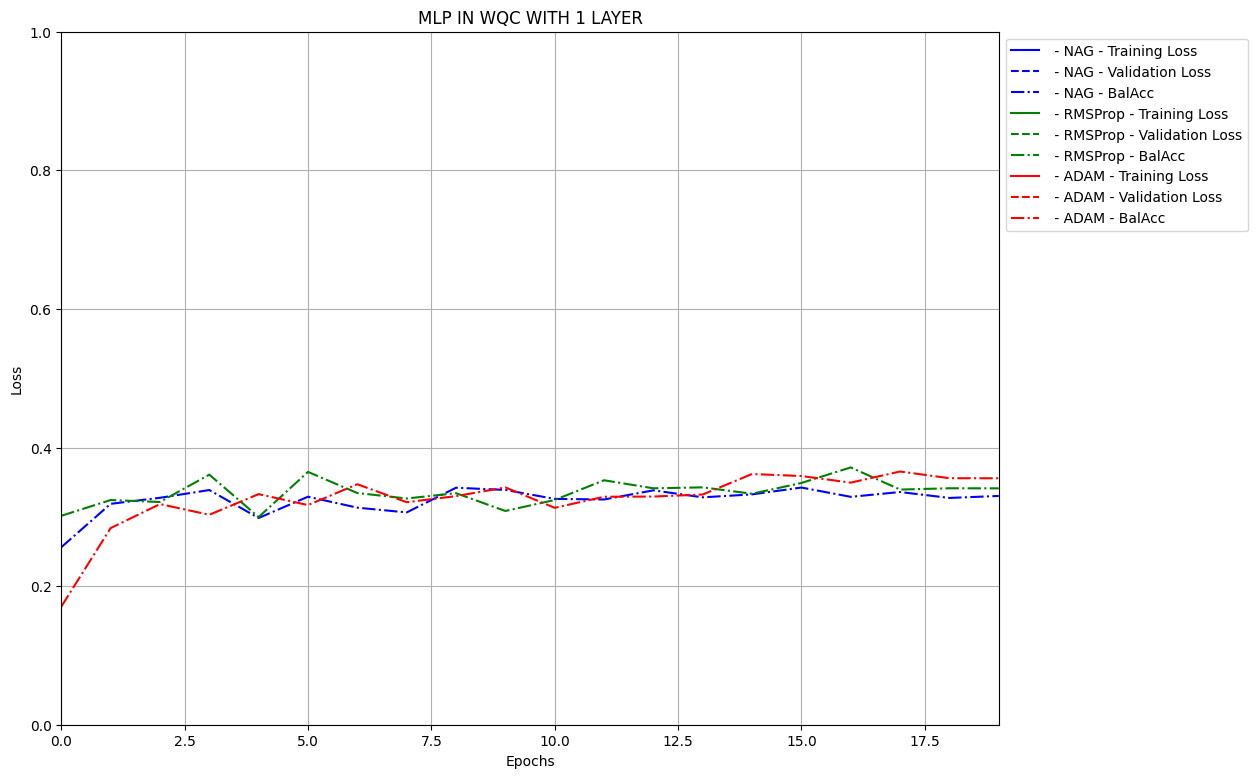

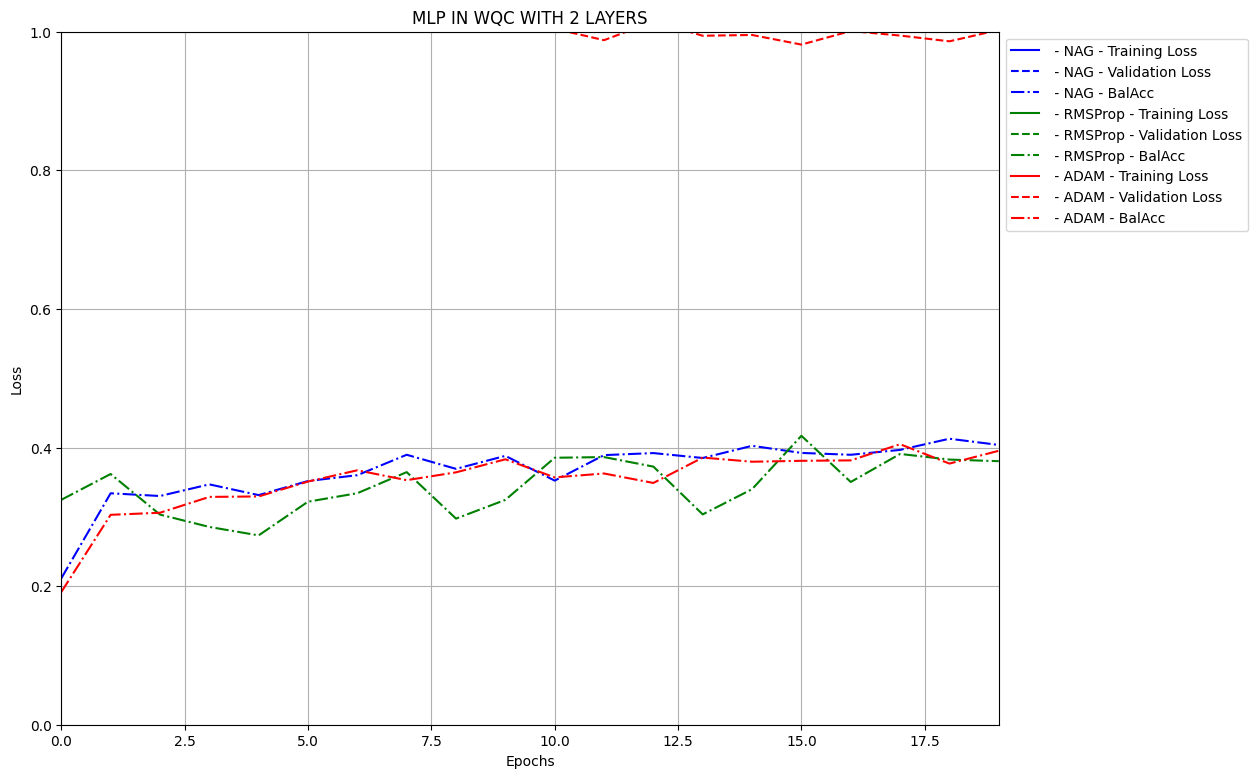

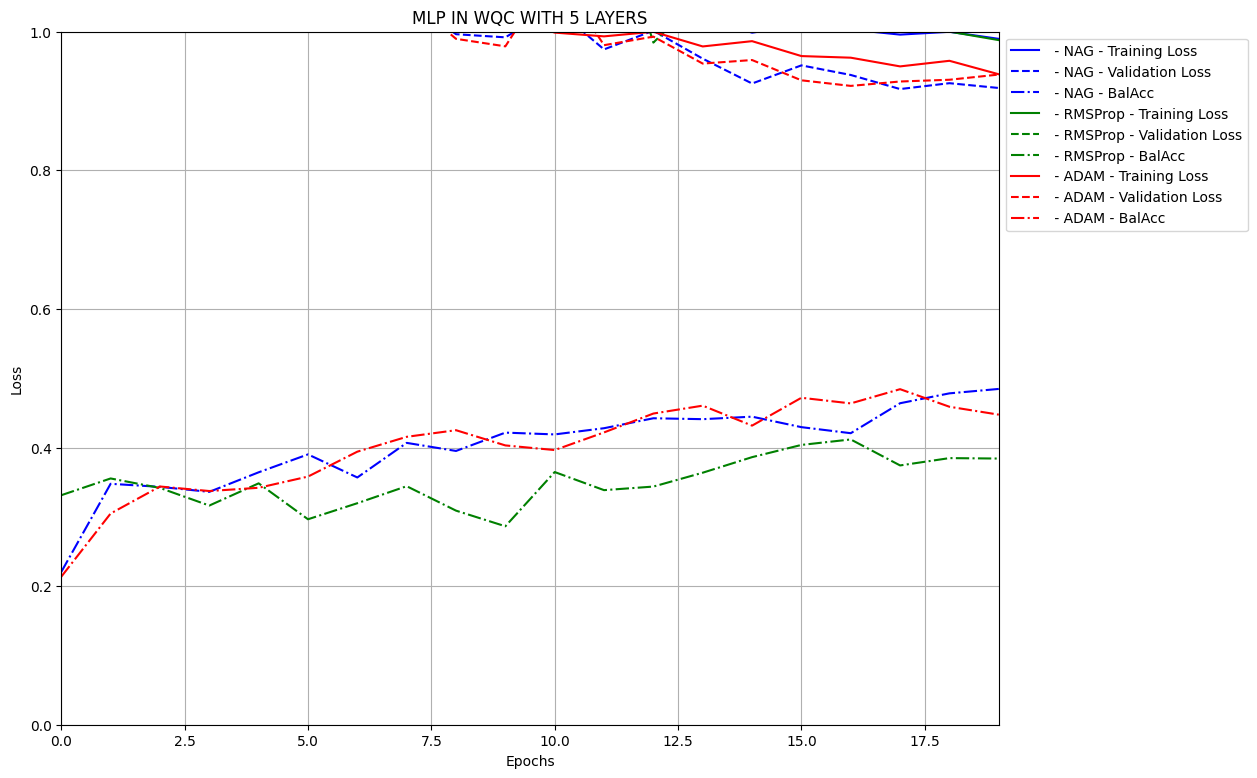

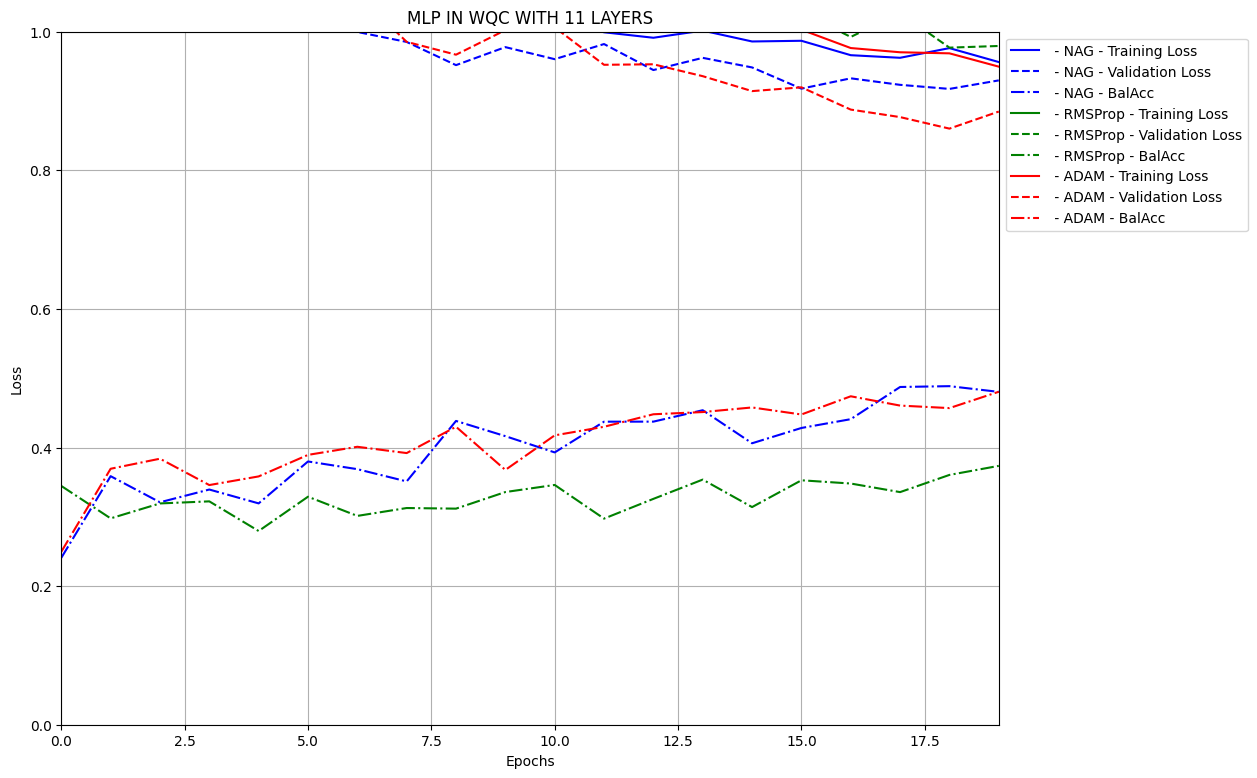

In [24]:
#Compare the three optimizers for each layer

learners_1_layer = [learners['NAG'][1], learners['RMSProp'][1], learners['ADAM'][1]]
learners_2_layers = [learners['NAG'][2], learners['RMSProp'][2], learners['ADAM'][2]]
learners_5_layers = [learners['NAG'][5], learners['RMSProp'][5], learners['ADAM'][5]]
learners_11_layers = [learners['NAG'][11], learners['RMSProp'][11], learners['ADAM'][11]]

names=['NAG', 'RMSProp', 'ADAM']
utilsTFG.plot_learners_training(learners_1_layer, title=f'MLP IN {plot_dataset} WITH 1 LAYER', names=names, metric=metric)
utilsTFG.plot_learners_training(learners_2_layers, title=f'MLP IN {plot_dataset} WITH 2 LAYERS', names=names, metric=metric)
utilsTFG.plot_learners_training(learners_5_layers, title=f'MLP IN {plot_dataset} WITH 5 LAYERS', names=names, metric=metric)
utilsTFG.plot_learners_training(learners_11_layers, title=f'MLP IN {plot_dataset} WITH 11 LAYERS', names=names, metric=metric)

### Generalization

In [25]:
#Run the model in the test set
for optim in optims:
  for layer in n_layers:
    #Run the model with optimizer optim and n_layers layer the test set in evaluation mode
    learners[optim][layer].model.eval()
    learners[optim][layer].eval()
    preds, targs = learners[optim][layer].get_preds(dl=test_dl)
    targs = targs.long().squeeze()

    # Calculate bal_accuracy
    accuracy = utilsTFG.balanced_accuracy_func(preds, targs)

    #Calculate loss
    loss = utilsTFG.err_param_w_model(learners[optim][layer].model, test_dl, mode = 'test')


    print(f"Optimizer: {optim}, Layers: {layer}, Loss: {loss}, Balanced Accuracy: {accuracy}")

Optimizer: NAG, Layers: 1, Loss: 1.1199793815612793, Balanced Accuracy: 0.2587962942200544


Optimizer: NAG, Layers: 2, Loss: 1.0733542442321777, Balanced Accuracy: 0.31099225974714345


Optimizer: NAG, Layers: 5, Loss: 0.9894826412200928, Balanced Accuracy: 0.33960209736215136


Optimizer: NAG, Layers: 11, Loss: 0.9927101135253906, Balanced Accuracy: 0.3351350271870465


Optimizer: RMSProp, Layers: 1, Loss: 1.1233019828796387, Balanced Accuracy: 0.2621194007960716


Optimizer: RMSProp, Layers: 2, Loss: 1.1068943738937378, Balanced Accuracy: 0.2615325154923327


Optimizer: RMSProp, Layers: 5, Loss: 1.050290584564209, Balanced Accuracy: 0.24913204974743877


Optimizer: RMSProp, Layers: 11, Loss: 1.05408775806427, Balanced Accuracy: 0.26747472716139187


Optimizer: ADAM, Layers: 1, Loss: 1.0863184928894043, Balanced Accuracy: 0.2903715724817091


Optimizer: ADAM, Layers: 2, Loss: 1.04383385181427, Balanced Accuracy: 0.28914773034097047


Optimizer: ADAM, Layers: 5, Loss: 0.9800558090209961, Balanced Accuracy: 0.3536511598051644


Optimizer: ADAM, Layers: 11, Loss: 0.9639509320259094, Balanced Accuracy: 0.4257112202412965


## Metaheuristics

In [26]:
#Initialise dictionaries
pop_size=10
population = {}
fitness = {}
mh_learners = {}
results = {}
fitness_valid = {}
best = {}
time_mh = {}

#Initialise the population to have the same values for all the MH
for n_layer,layer in zip(n_layers,layers):
  population[n_layer] = []
  fitness[n_layer] = []
  mh_learners[n_layer] = tabular_learner(dls, n_out=10, loss_func=CrossEntropyLossFlat(), layers=layer, cbs=[SaveModelCallback()])
  mh_learners[n_layer].to(device)
  mh_learners[n_layer].model.to(device)
  for _ in range(pop_size):
    model_copy = copy.deepcopy(mh_learners[n_layer].model)

    # Reset the weights of the model copy
    model_copy.apply(utilsTFG.init_weights_glorot)

    # Add the reinitialized model to the population list
    population[n_layer].append(utilsTFG.get_params_from_model(model_copy))

    fitness[n_layer].append(utilsTFG.err_param_w_model(model_copy, dls))

#More initialisation
for alg in algs:
  results[alg] = {}
  fitness_valid[alg] = {}
  best[alg] = {}
  time_mh[alg] = {}

max_evals=4200
max_evals_shade=200
max_ls=10


### Genetic Algorithms

In [27]:
#Genetic Algorithm working as supposed to (terrible performance)
#results['GA'] = {}
#for layer in n_layers:
#  start = time.perf_counter()
#  results['GA'][layer] = utilsTFG.gen_alg(pop_size, copy.deepcopy(population[layer]), fitness[layer], dls, 4000, mh_learners[layer])
#  end = time.perf_counter()
#  time_mh['GA'][layer] = end-start

### SHADE

In [28]:
#Runing SHADE algorithm

results['SHADE'] = {}
for layer in n_layers:
  start = time.perf_counter()
  results['SHADE'][layer] = utilsTFG.SHADE_ej(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]), pop_size,max_evals, len(population[layer][0]), dls,  model=mh_learners[layer].model)
  end = time.perf_counter()
  time_mh['SHADE'][layer] = end-start


In [29]:
#Validate the models obtained.
fitness_valid['SHADE'] = {}
for layer in n_layers:
  fitness_valid['SHADE'][layer] = []
  for ind in results['SHADE'][layer][5]:
    fitness_valid['SHADE'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls))

In [30]:
#compare train and valid and select the best generalizing model.
for layer in n_layers:
  print(f"Training error of SHADE for {layer} layers: {results['SHADE'][layer][6]}")
  print(f"Validation error of SHADE for {layer} layers: {fitness_valid['SHADE'][layer]}")
  dif = np.array(fitness_valid['SHADE'][layer]) - np.array(results['SHADE'][layer][6])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE'][layer])
  best['SHADE'][layer] = results['SHADE'][layer][5][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")

  print("\n")

Training error of SHADE for 1 layers: [2.6828105449676514, 2.5187020301818848, 2.4896676540374756, 2.432378053665161, 2.4065871238708496, 2.4028520584106445, 2.4028520584106445, 2.3765757083892822, 2.3291571140289307, 2.30431866645813, 2.289156198501587, 2.27620530128479, 2.2588961124420166, 2.251899242401123, 2.2472755908966064, 2.2451577186584473, 2.2451577186584473, 2.2332239151000977, 2.2332239151000977, 2.224005937576294, 2.208437919616699, 2.208437919616699, 2.208437919616699, 2.208437919616699, 2.200228452682495, 2.200228452682495, 2.200228452682495, 2.198591709136963, 2.198591709136963, 2.198591709136963, 2.198591709136963, 2.198591709136963, 2.198591709136963, 2.198591709136963, 2.198591709136963, 2.198591709136963, 2.198591709136963, 2.198591709136963, 2.198591709136963, 2.198591709136963, 2.198591709136963, 2.198591709136963, 2.198591709136963, 2.198591709136963, 2.198591709136963, 2.198591709136963, 2.198591709136963, 2.198591709136963, 2.198591709136963, 2.198591709136963,

### SHADE-ILS

In [31]:
# Running SHADE-ILS algorithm
results['SHADE-ILS'] = {}
for layer in n_layers:
  start = time.perf_counter()
  results['SHADE-ILS'][layer] = utilsTFG.SHADE_ILS(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]), max_evals, max_evals_shade, dls, mh_learners[layer], mh_learners[layer].model, max_ls=max_ls)
  end = time.perf_counter()
  time_mh['SHADE-ILS'][layer] = end-start


eo
deque([1, 0.5550116182832953, 0.0], maxlen=3)
deque([0.5550116182832953, 0.0, 0.00039273116817601386], maxlen=3)
256
eo
deque([0.0, 0.00039273116817601386, 0.023324390435651345], maxlen=3)
deque([0.00039273116817601386, 0.023324390435651345, -0.024347500746901344], maxlen=3)
Reiniciado
474
eo
deque([1, 1, 0.702760948226588], maxlen=3)
deque([1, 0.702760948226588, 0.4678708862207178], maxlen=3)
692
eo
deque([0.702760948226588, 0.4678708862207178, 0.0], maxlen=3)
deque([0.4678708862207178, 0.0, -0.024281258281559217], maxlen=3)
905
eo
deque([0.0, -0.024281258281559217, 0.01268731323573455], maxlen=3)
deque([-0.024281258281559217, 0.01268731323573455, -0.011554091219772075], maxlen=3)
Reiniciado
1130
eo
deque([1, 1, 0.7137346265996951], maxlen=3)
deque([1, 0.7137346265996951, 0.43832500333612606], maxlen=3)
1349
eo
deque([0.7137346265996951, 0.43832500333612606, 0.013474018220495178], maxlen=3)
deque([0.43832500333612606, 0.013474018220495178, -0.006909661909362425], maxlen=3)
1564
eo


In [32]:
#Validation error
fitness_valid['SHADE-ILS'] = {}
for layer in n_layers:
  fitness_valid['SHADE-ILS'][layer] = []
  for ind in results['SHADE-ILS'][layer][3]:
    fitness_valid['SHADE-ILS'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls))

In [33]:
#Compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE-ILS for {layer} layers: {results['SHADE-ILS'][layer][2]}")
  print(f"Validation error of SHADE-ILS for {layer} layers: {fitness_valid['SHADE-ILS'][layer]}")
  dif = np.array(fitness_valid['SHADE-ILS'][layer]) - np.array(results['SHADE-ILS'][layer][2])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE-ILS'][layer])
  best['SHADE-ILS'][layer] = results['SHADE-ILS'][layer][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-ILS for 1 layers: [2.6828105449676514, 1.193819522857666, 1.1933506727218628, 1.1933506727218628, 1.144816279411316, 1.144816279411316, 1.144816279411316, 1.144816279411316, 1.144816279411316, 1.1357001066207886, 1.1357001066207886, 1.1357001066207886, 1.121495246887207, 1.121495246887207, 1.110622763633728, 1.110622763633728, 1.110622763633728, 1.110622763633728, 1.110622763633728, 1.110622763633728, 1.110622763633728, 1.110622763633728]
Validation error of SHADE-ILS for 1 layers: [3.0561468601226807, 2.075831890106201, 1.9143280982971191, 1.9143280982971191, 3.7453129291534424, 3.7453129291534424, 3.7453129291534424, 3.7453129291534424, 3.7453129291534424, 4.386594772338867, 4.386594772338867, 4.386594772338867, 2.0664589405059814, 2.0664589405059814, 3.1682043075561523, 3.1682043075561523, 3.1682043075561523, 3.1682043075561523, 3.1682043075561523, 3.1682043075561523, 3.1682043075561523, 3.1682043075561523]
Difference: [0.37333632 0.88201237 0.72097743 0.7209

In [35]:
file_path = f'/notebooks/saved_models/SHADE_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE'], f)
    
file_path = f'/notebooks/saved_models/SHADE-ILS_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE-ILS'], f)
    


In [37]:
file_path = f'/notebooks/saved_models/SHADE_time_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE'], f)
    
file_path = f'/notebooks/saved_models/SHADE-ILS_time_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE-ILS'], f)

### SHADE-GD

eo
deque([1, 1, 0.10435268605982853], maxlen=3)
deque([1, 1, 0.10435268605982853], maxlen=3)
eo
deque([1, 0.10435268605982853, 0.007784354729948289], maxlen=3)
deque([1, 0.10435268605982853, 0.007784354729948289], maxlen=3)
eo
deque([0.10435268605982853, 0.007784354729948289, 0.025961317977219435], maxlen=3)
deque([0.10435268605982853, 0.007784354729948289, 0.025961317977219435], maxlen=3)
eo
deque([0.007784354729948289, 0.025961317977219435, 0.019295540249049562], maxlen=3)
deque([0.007784354729948289, 0.025961317977219435, 0.019295540249049562], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.42240985931332614], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.146796464920044.
deque([1, 0.42240985931332614, 0.4063386367744233], maxlen=3)
eo
deque([0.42240985931332614, 0.4063386367744233, 0.07233608947385346], maxlen=3)
deque([0.42240985931332614, 0.4063386367744233, 0.07233608947385346], maxlen=3)
eo
deque([0.4063386367744233, 0.07233608947385346, 0.07655757046446729], maxlen=3)
deque([0.4063386367744233, 0.07233608947385346, 0.07655757046446729], maxlen=3)
eo
deque([0.07233608947385346, 0.07655757046446729, 0.019329987160032685], maxlen=3)
deque([0.07233608947385346, 0.07655757046446729, 0.019329987160032685], maxlen=3)
eo
deque([0.07655757046446729, 0.019329987160032685, 0.017974051943723666], maxlen=3)
deque([0.07655757046446729, 0.019329987160032685, 0.017974051943723666], maxlen=3)
eo
deque([0.019329987160032685, 0.017974051943723666, 0.0053327885188690655], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.0597985982894897.
deque([0.017974051943723666, 0.0053327885188690655, 0.06652733468161513], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.39471898370074576], maxlen=3)
deque([1, 1, 0.39471898370074576], maxlen=3)
eo
deque([1, 0.39471898370074576, 0.08958466187488397], maxlen=3)
deque([1, 0.39471898370074576, 0.08958466187488397], maxlen=3)
eo
deque([0.39471898370074576, 0.08958466187488397, 0.03680692571000268], maxlen=3)
deque([0.39471898370074576, 0.08958466187488397, 0.03680692571000268], maxlen=3)
eo
deque([0.08958466187488397, 0.03680692571000268, 0.05841144385592837], maxlen=3)
deque([0.08958466187488397, 0.03680692571000268, 0.05841144385592837], maxlen=3)
eo
deque([0.03680692571000268, 0.05841144385592837, 0.020628723564996218], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.0652120113372803.
deque([0.05841144385592837, 0.020628723564996218, 0.11837006840772907], maxlen=3)
eo
deque([0.020628723564996218, 0.11837006840772907, 0.04757493231533467], maxlen=3)
deque([0.020628723564996218, 0.11837006840772907, 0.04757493231533467], maxlen=3)
eo
deque([0.11837006840772907, 0.04757493231533467, 0.0], maxlen=3)
deque([0.11837006840772907, 0.04757493231533467, 0.0], maxlen=3)
eo
deque([0.04757493231533467, 0.0, 8.990339259527212e-05], maxlen=3)
deque([0.04757493231533467, 0.0, 8.990339259527212e-05], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.4169855161871829], maxlen=3)
deque([1, 1, 0.4169855161871829], maxlen=3)
eo
deque([1, 0.4169855161871829, 0.07916143198541968], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.12186861038208.
deque([0.4169855161871829, 0.07916143198541968, 0.24153538935985508], maxlen=3)
eo
deque([0.07916143198541968, 0.24153538935985508, 0.0796962457924901], maxlen=3)
deque([0.07916143198541968, 0.24153538935985508, 0.0796962457924901], maxlen=3)
eo
deque([1, 1, 0.09953712607646781], maxlen=3)
deque([1, 1, 0.09953712607646781], maxlen=3)
eo
deque([1, 0.09953712607646781, 0.047347588826226854], maxlen=3)
deque([1, 0.09953712607646781, 0.047347588826226854], maxlen=3)
eo
deque([0.09953712607646781, 0.047347588826226854, 0.013567678675592344], maxlen=3)
deque([0.09953712607646781, 0.047347588826226854, 0.013567678675592344], maxlen=3)
eo
deque([0.047347588826226854, 0.013567678675592344, 0.007271171941830625], maxlen=3)
deque([0.047347588826226854, 0.013567678675592344, 0.007271171941830625], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.47582498277132845], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.2047324180603027.
deque([1, 0.47582498277132845, 0.4027492227852404], maxlen=3)
eo
deque([0.47582498277132845, 0.4027492227852404, 0.15512642611005487], maxlen=3)
deque([0.47582498277132845, 0.4027492227852404, 0.15512642611005487], maxlen=3)
eo
deque([0.4027492227852404, 0.15512642611005487, 0.02643971250741017], maxlen=3)
deque([0.4027492227852404, 0.15512642611005487, 0.02643971250741017], maxlen=3)
eo
deque([0.15512642611005487, 0.02643971250741017, 0.005977080694808404], maxlen=3)
deque([0.15512642611005487, 0.02643971250741017, 0.005977080694808404], maxlen=3)
eo
deque([0.02643971250741017, 0.005977080694808404, 0.005302628147587201], maxlen=3)
deque([0.02643971250741017, 0.005977080694808404, 0.005302628147587201], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.35380620033698146], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.0801608562469482.
deque([1, 0.35380620033698146, 0.40201027431806213], maxlen=3)
eo
deque([0.35380620033698146, 0.40201027431806213, 0.07142501846032302], maxlen=3)
deque([0.35380620033698146, 0.40201027431806213, 0.07142501846032302], maxlen=3)
eo
deque([0.40201027431806213, 0.07142501846032302, 0.025653322488842948], maxlen=3)
deque([0.40201027431806213, 0.07142501846032302, 0.025653322488842948], maxlen=3)
eo
deque([0.07142501846032302, 0.025653322488842948, 0.0], maxlen=3)
deque([0.07142501846032302, 0.025653322488842948, 0.0], maxlen=3)
eo
deque([0.025653322488842948, 0.0, 0.0], maxlen=3)
deque([0.025653322488842948, 0.0, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.35605128446615036], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.0896167755126953.
deque([1, 0.35605128446615036, 0.32871054526417504], maxlen=3)
eo
deque([0.35605128446615036, 0.32871054526417504, 0.053966379748388305], maxlen=3)
deque([0.35605128446615036, 0.32871054526417504, 0.053966379748388305], maxlen=3)
eo
deque([0.32871054526417504, 0.053966379748388305, 0.014874963805409038], maxlen=3)
deque([0.32871054526417504, 0.053966379748388305, 0.014874963805409038], maxlen=3)
eo
deque([0.053966379748388305, 0.014874963805409038, 0.008755790698683229], maxlen=3)
deque([0.053966379748388305, 0.014874963805409038, 0.008755790698683229], maxlen=3)
eo
deque([0.014874963805409038, 0.008755790698683229, 0.004585416025102569], maxlen=3)
deque([0.014874963805409038, 0.008755790698683229, 0.004585416025102569], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.46954462139469666], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.068509578704834.
deque([1, 0.46954462139469666, 0.31240120079978156], maxlen=3)
eo
deque([0.46954462139469666, 0.31240120079978156, 0.05235932803516619], maxlen=3)
deque([0.46954462139469666, 0.31240120079978156, 0.05235932803516619], maxlen=3)
eo
deque([1, 1, 0.08925723887473207], maxlen=3)
deque([1, 1, 0.08925723887473207], maxlen=3)
eo
deque([1, 0.08925723887473207, 0.03376171341308135], maxlen=3)
deque([1, 0.08925723887473207, 0.03376171341308135], maxlen=3)
eo
deque([0.08925723887473207, 0.03376171341308135, 0.021479599258867586], maxlen=3)
deque([0.08925723887473207, 0.03376171341308135, 0.021479599258867586], maxlen=3)
eo
deque([0.03376171341308135, 0.021479599258867586, 0.00240261092292802], maxlen=3)
deque([0.03376171341308135, 0.021479599258867586, 0.00240261092292802], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.5018587233882612], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.789037823677063.
deque([1, 0.5018587233882612, 0.2696353973738284], maxlen=3)
eo
deque([0.5018587233882612, 0.2696353973738284, 0.02804476405992005], maxlen=3)
deque([0.5018587233882612, 0.2696353973738284, 0.02804476405992005], maxlen=3)
eo
deque([0.2696353973738284, 0.02804476405992005, 0.0008916729689251547], maxlen=3)
deque([0.2696353973738284, 0.02804476405992005, 0.0008916729689251547], maxlen=3)
eo
deque([0.02804476405992005, 0.0008916729689251547, 0.011393366605841117], maxlen=3)
deque([0.02804476405992005, 0.0008916729689251547, 0.011393366605841117], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.41453563866076704], maxlen=3)
deque([1, 1, 0.41453563866076704], maxlen=3)
eo
deque([1, 0.41453563866076704, 0.0377034928419823], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.3767292499542236.
deque([0.41453563866076704, 0.0377034928419823, 0.31062831459271584], maxlen=3)
eo
deque([0.0377034928419823, 0.31062831459271584, 0.1837119220638792], maxlen=3)
deque([0.0377034928419823, 0.31062831459271584, 0.1837119220638792], maxlen=3)
eo
deque([0.31062831459271584, 0.1837119220638792, 0.015883048478985272], maxlen=3)
deque([0.31062831459271584, 0.1837119220638792, 0.015883048478985272], maxlen=3)
eo
deque([0.1837119220638792, 0.015883048478985272, 0.007511968834352831], maxlen=3)
deque([0.1837119220638792, 0.015883048478985272, 0.007511968834352831], maxlen=3)
eo
deque([0.015883048478985272, 0.007511968834352831, 0.010168430806399578], maxlen=3)
deque([0.015883048478985272, 0.007511968834352831, 0.010168430806399578], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.34472137972481615], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.08286452293396.
deque([1, 0.34472137972481615, 0.4437254701594642], maxlen=3)
eo
deque([0.34472137972481615, 0.4437254701594642, 0.005577984338096306], maxlen=3)
deque([0.34472137972481615, 0.4437254701594642, 0.005577984338096306], maxlen=3)
eo
deque([0.4437254701594642, 0.005577984338096306, 0.03168481365769237], maxlen=3)
deque([0.4437254701594642, 0.005577984338096306, 0.03168481365769237], maxlen=3)
eo
deque([0.005577984338096306, 0.03168481365769237, 0.006087666705802208], maxlen=3)
deque([0.005577984338096306, 0.03168481365769237, 0.006087666705802208], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.36666933285515724], maxlen=3)
deque([1, 1, 0.36666933285515724], maxlen=3)
eo
deque([1, 0.36666933285515724, 0.0713758536466485], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.0540469884872437.
deque([0.36666933285515724, 0.0713758536466485, 0.3907861875393364], maxlen=3)
eo
deque([0.0713758536466485, 0.3907861875393364, 0.07081128376360309], maxlen=3)
deque([0.0713758536466485, 0.3907861875393364, 0.07081128376360309], maxlen=3)
eo
deque([1, 1, 0.14046937800077097], maxlen=3)
deque([1, 1, 0.14046937800077097], maxlen=3)
eo
deque([1, 0.14046937800077097, 0.008511452765959023], maxlen=3)
deque([1, 0.14046937800077097, 0.008511452765959023], maxlen=3)
eo
deque([0.14046937800077097, 0.008511452765959023, 0.008784934383537476], maxlen=3)
deque([0.14046937800077097, 0.008511452765959023, 0.008784934383537476], maxlen=3)
eo
deque([0.008511452765959023, 0.008784934383537476, 0.00780305018048458], maxlen=3)
deque([0.008511452765959023, 0.008784934383537476, 0.00780305018048458], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.17398039548548203], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.7395775318145752.
deque([1, 0.17398039548548203, 0.26430091643910664], maxlen=3)
eo
deque([0.17398039548548203, 0.26430091643910664, 0.12375754616176614], maxlen=3)
deque([0.17398039548548203, 0.26430091643910664, 0.12375754616176614], maxlen=3)
eo
deque([0.26430091643910664, 0.12375754616176614, 0.035048728946800035], maxlen=3)
deque([0.26430091643910664, 0.12375754616176614, 0.035048728946800035], maxlen=3)
eo
deque([0.12375754616176614, 0.035048728946800035, 0.013592797959730943], maxlen=3)
deque([0.12375754616176614, 0.035048728946800035, 0.013592797959730943], maxlen=3)
eo
deque([0.035048728946800035, 0.013592797959730943, 0.0], maxlen=3)
deque([0.035048728946800035, 0.013592797959730943, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.17380127740127752], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.0982571840286255.
deque([1, 0.17380127740127752, 0.4119996309266527], maxlen=3)
eo
deque([0.17380127740127752, 0.4119996309266527, 0.06380816633700444], maxlen=3)
deque([0.17380127740127752, 0.4119996309266527, 0.06380816633700444], maxlen=3)
eo
deque([0.4119996309266527, 0.06380816633700444, 0.031904451122912465], maxlen=3)
deque([0.4119996309266527, 0.06380816633700444, 0.031904451122912465], maxlen=3)
eo
deque([0.06380816633700444, 0.031904451122912465, 0.0], maxlen=3)
deque([0.06380816633700444, 0.031904451122912465, 0.0], maxlen=3)
eo
deque([0.031904451122912465, 0.0, 0.002102537546396187], maxlen=3)
deque([0.031904451122912465, 0.0, 0.002102537546396187], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.1435039942292681], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.081447958946228.
deque([1, 0.1435039942292681, 0.2779511574865313], maxlen=3)
eo
deque([0.1435039942292681, 0.2779511574865313, 0.09324798503058869], maxlen=3)
deque([0.1435039942292681, 0.2779511574865313, 0.09324798503058869], maxlen=3)
eo
deque([0.2779511574865313, 0.09324798503058869, 0.00646286765269969], maxlen=3)
deque([0.2779511574865313, 0.09324798503058869, 0.00646286765269969], maxlen=3)
eo
deque([0.09324798503058869, 0.00646286765269969, 0.00422722631829275], maxlen=3)
deque([0.09324798503058869, 0.00646286765269969, 0.00422722631829275], maxlen=3)
eo
deque([0.00646286765269969, 0.00422722631829275, 0.0], maxlen=3)
deque([0.00646286765269969, 0.00422722631829275, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.2794236482281496], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.0969276428222656.
deque([1, 0.2794236482281496, 0.256645353970502], maxlen=3)
eo
deque([0.2794236482281496, 0.256645353970502, 0.01874098717937476], maxlen=3)
deque([0.2794236482281496, 0.256645353970502, 0.01874098717937476], maxlen=3)


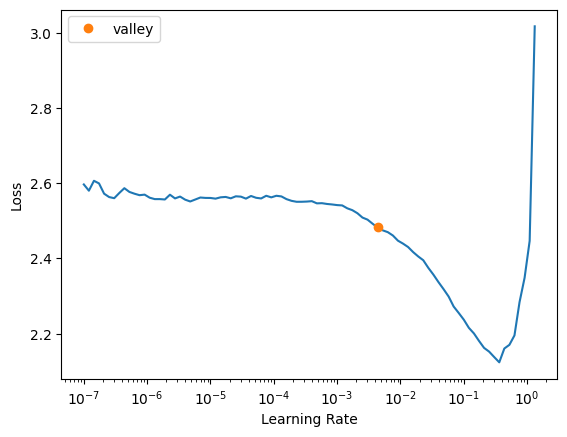

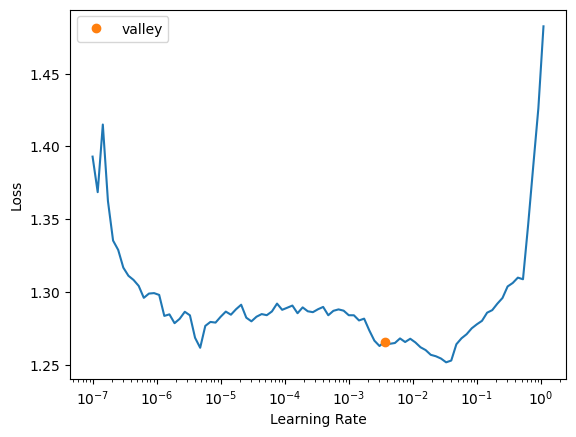

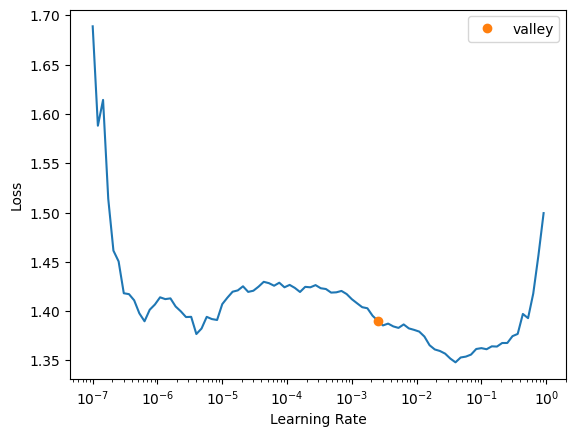

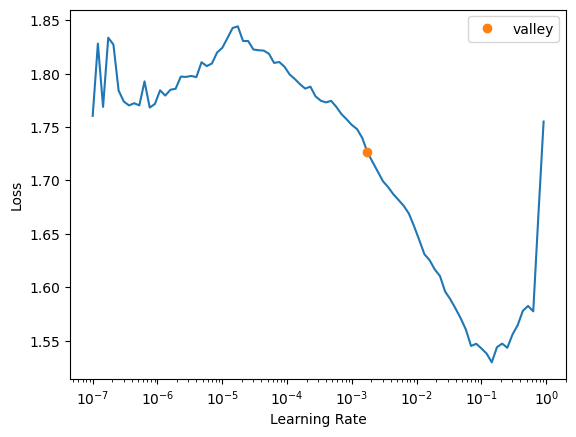

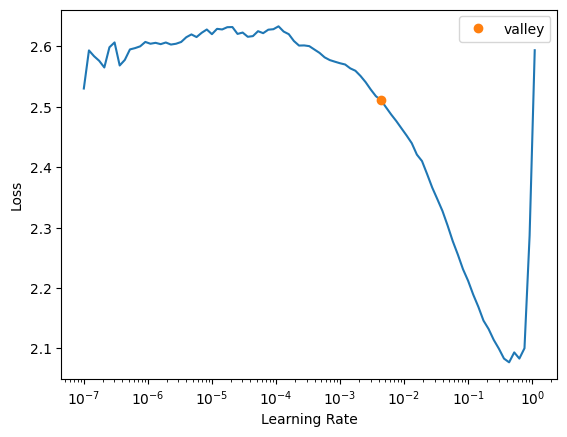

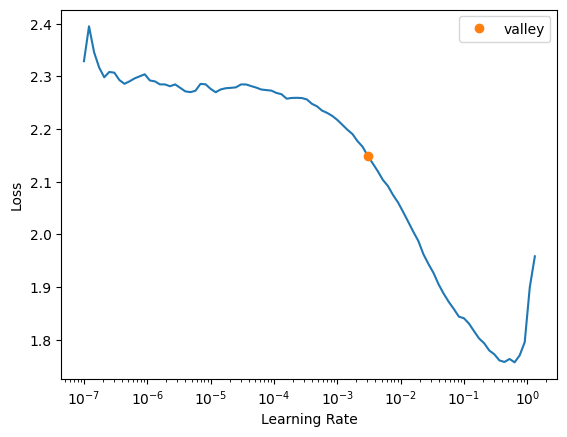

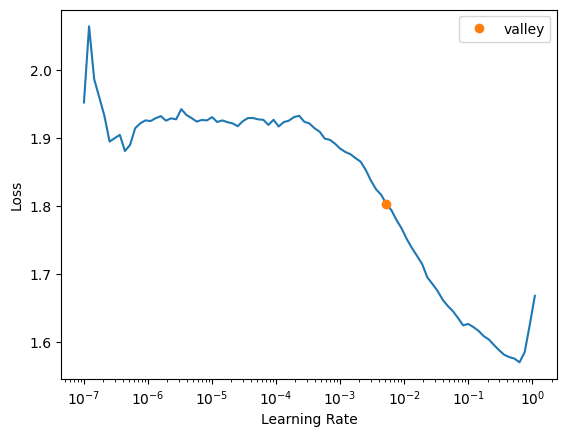

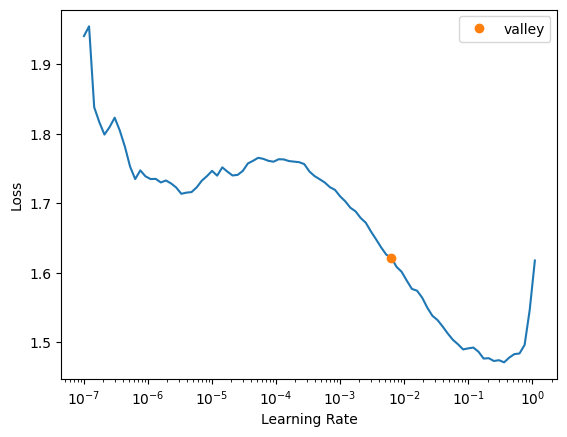

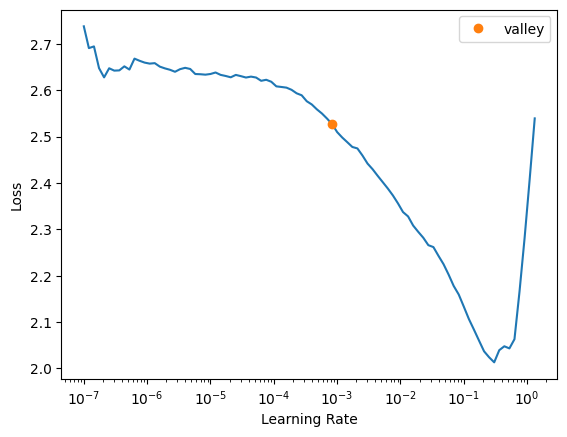

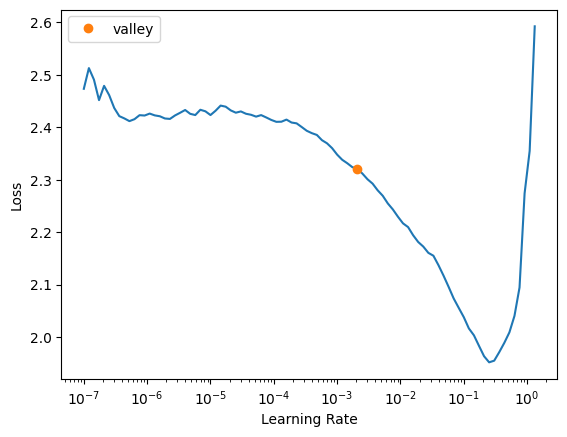

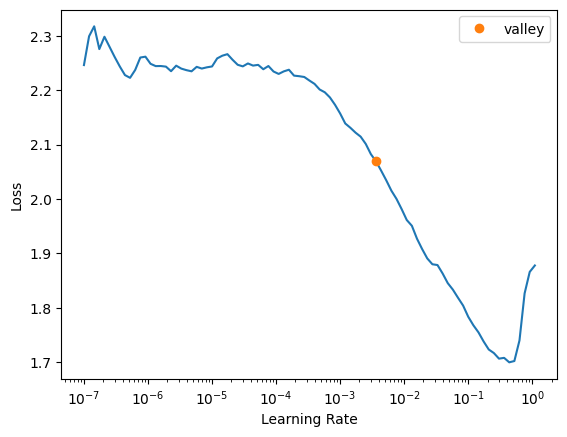

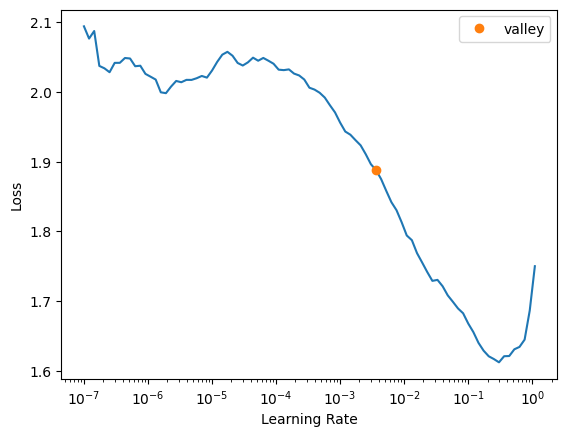

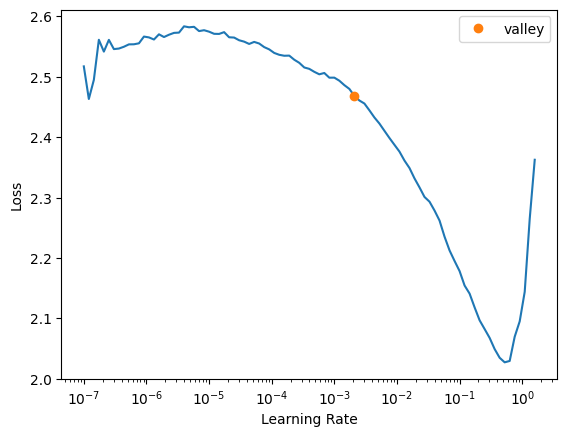

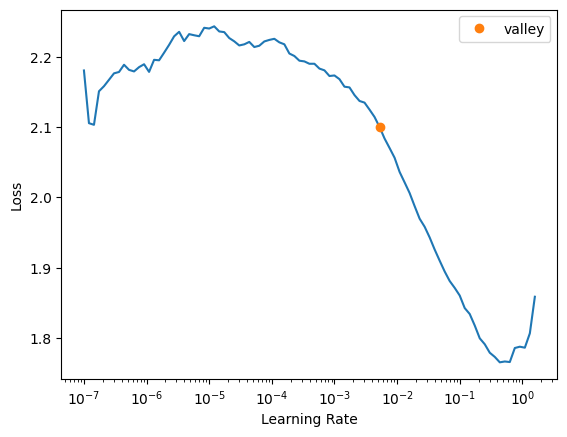

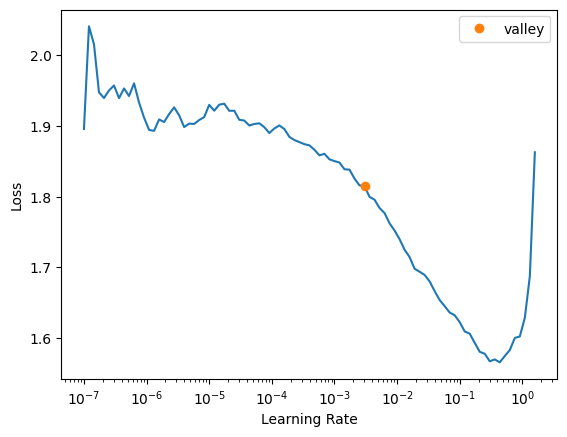

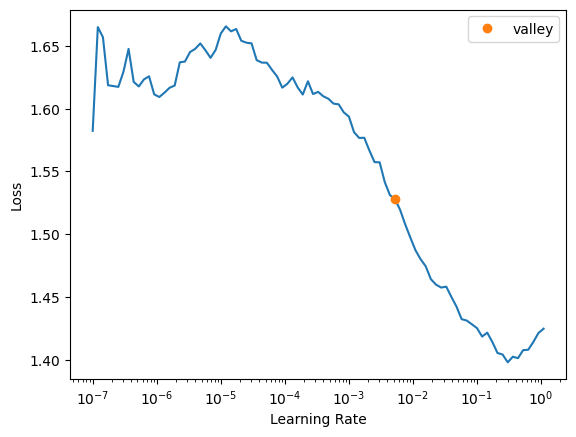

In [38]:
# Running SHADE algorithm with GD
results['SHADE-GD'] = {}
for layer in n_layers:
  start = time.perf_counter()
  results['SHADE-GD'][layer] = utilsTFG.SHADE_GD(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]), max_evals, max_evals_shade, dls, mh_learners[layer], mh_learners[layer].model)
  end = time.perf_counter()
  time_mh['SHADE-GD'][layer] = end-start


In [39]:
#Validation error
fitness_valid['SHADE-GD'] = {}
for layer in n_layers:
  fitness_valid['SHADE-GD'][layer] = []
  for ind in results['SHADE-GD'][layer][3]:
    fitness_valid['SHADE-GD'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls))

In [40]:
#Compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE-GD for {layer} layers: {results['SHADE-GD'][layer][2]}")
  print(f"Validation error of SHADE-GD for {layer} layers: {fitness_valid['SHADE-GD'][layer]}")
  dif = np.array(fitness_valid['SHADE-GD'][layer]) - np.array(results['SHADE-GD'][layer][2])
  print(f"Difference: {dif}")
  #mejor = np.argmin(dif)
  mejor = np.argmin(fitness_valid['SHADE-GD'][layer])
  best['SHADE-GD'][layer] = results['SHADE-GD'][layer][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-GD for 1 layers: [2.6828105449676514, 2.4028520584106445, 2.3841474056243896, 2.322251796722412, 2.277442693710327, 1.49021315574646, 1.3824169635772705, 1.2765824794769287, 1.251906156539917, 1.229404330253601, 1.1414953470230103, 1.1414953470230103, 1.1414953470230103, 1.1414953470230103, 1.1414953470230103, 1.1414953470230103, 1.1230974197387695, 1.1230974197387695, 1.12299644947052, 1.12299644947052, 1.12299644947052, 1.12299644947052]
Validation error of SHADE-GD for 1 layers: [3.3286256790161133, 2.4878194332122803, 2.5134270191192627, 2.760664701461792, 2.6831703186035156, 1.6436378955841064, 2.7044639587402344, 2.2823171615600586, 2.435199737548828, 2.4217653274536133, 2.1710126399993896, 2.1710126399993896, 2.1710126399993896, 2.1710126399993896, 2.1710126399993896, 2.1710126399993896, 1.4662209749221802, 1.4662209749221802, 1.4285027980804443, 1.4285027980804443, 1.4285027980804443, 1.4285027980804443]
Difference: [0.64581513 0.08496737 0.12927961 0.43

### SHADE-ILS-GD

deque([1, 1, 0.5434515441559196], maxlen=3)
eo
deque([1, 0.5434515441559196, 0.0], maxlen=3)
deque([0.5434515441559196, 0.0, -0.011501615043791298], maxlen=3)
deque([0.0, -0.011501615043791298, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.377551866410464], maxlen=3)
deque([1, 0.377551866410464, 0.37004670538582884], maxlen=3)
deque([0.377551866410464, 0.37004670538582884, 0.0], maxlen=3)
eo
deque([0.37004670538582884, 0.0, 0.004372019784102712], maxlen=3)
deque([0.0, 0.004372019784102712, 0.01916824133249695], maxlen=3)
deque([0.004372019784102712, 0.01916824133249695, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.37711741723577175], maxlen=3)
deque([1, 0.37711741723577175, 0.328700673754283], maxlen=3)
deque([0.37711741723577175, 0.328700673754283, 0.0], maxlen=3)
eo
deque([0.328700673754283, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.00027148338333568057], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.0601136684417725.
deque([0.0, 0.00027148338333568057, 0.0038317414701490434], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.5665234267466654], maxlen=3)
deque([1, 0.5665234267466654, 0.2899742208679899], maxlen=3)
deque([0.5665234267466654, 0.2899742208679899, 0.0], maxlen=3)
eo
deque([0.2899742208679899, 0.0, 0.00637176786339798], maxlen=3)
deque([0.0, 0.00637176786339798, 0.005376751183592809], maxlen=3)
deque([0.00637176786339798, 0.005376751183592809, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.5311016857562096], maxlen=3)
deque([1, 0.5311016857562096, 0.36199329878736325], maxlen=3)
deque([0.5311016857562096, 0.36199329878736325, 0.0], maxlen=3)
eo
deque([0.36199329878736325, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, -0.017690321779323438], maxlen=3)
deque([0.0, -0.017690321779323438, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.3740857551458195], maxlen=3)
deque([1, 0.3740857551458195, 0.21517468151739283], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.0794880390167236.
deque([0.3740857551458195, 0.21517468151739283, -0.08905939392388278], maxlen=3)
eo
deque([0.21517468151739283, -0.08905939392388278, 0.08177643425213169], maxlen=3)
deque([-0.08905939392388278, 0.08177643425213169, 0.03072129848203042], maxlen=3)
deque([0.08177643425213169, 0.03072129848203042, 0.0], maxlen=3)
eo
deque([0.03072129848203042, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, -0.017259738759478838], maxlen=3)
deque([0.0, -0.017259738759478838, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.487874009718986], maxlen=3)
deque([1, 0.487874009718986, 0.33047616195912904], maxlen=3)
deque([0.487874009718986, 0.33047616195912904, 0.0], maxlen=3)
eo
deque([0.33047616195912904, 0.0, 0.01310607336299771], maxlen=3)
deque([0.0, 0.01310607336299771, 0.010192455508383984], maxlen=3)
deque([0.01310607336299771, 0.010192455508383984, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.4758285238122698], maxlen=3)
deque([1, 0.475828523

Better model found at epoch 0 with valid_loss value: 1.0821340084075928.
deque([0.4758285238122698, 0.27703645198595417, -0.08730598025503591], maxlen=3)
eo
deque([0.27703645198595417, -0.08730598025503591, 0.08066656803754944], maxlen=3)
deque([-0.08730598025503591, 0.08066656803754944, 0.029442288951037274], maxlen=3)
deque([0.08066656803754944, 0.029442288951037274, 0.0], maxlen=3)
eo
deque([0.029442288951037274, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, -0.034738683695039047], maxlen=3)
deque([0.0, -0.034738683695039047, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.4872704771333917], maxlen=3)
deque([1, 0.4872704771333917, 0.2662900795333607], maxlen=3)
deque([0.4872704771333917, 0.2662900795333607, 0.0], maxlen=3)
eo
deque([0.2662900795333607, 0.0, 0.001978287825492826], maxlen=3)
deque([0.0, 0.001978287825492826, 0.009695623784319735], maxlen=3)
deque([0.001978287825492826, 0.009695623784319735, 0.0], maxlen=3)
Reiniciado
deque([1, 1, 0.5821236136844294], maxlen=3)
eo
deque([1, 0.582

Better model found at epoch 0 with valid_loss value: 1.1051524877548218.
deque([0.0, 0.023041996289545934, -0.0028252815694909173], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.32943189108472065], maxlen=3)
deque([1, 0.32943189108472065, 0.32027857008031474], maxlen=3)
deque([0.32943189108472065, 0.32027857008031474, 0.0], maxlen=3)
eo
deque([0.32027857008031474, 0.0, 0.03696620569328218], maxlen=3)
deque([0.0, 0.03696620569328218, -0.014811449331704654], maxlen=3)
deque([0.03696620569328218, -0.014811449331704654, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.3353097707286277], maxlen=3)
deque([1, 0.3353097707286277, 0.3244182630216952], maxlen=3)
deque([0.3353097707286277, 0.3244182630216952, 0.0], maxlen=3)
eo
deque([0.3244182630216952, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, -0.011254189092090515], maxlen=3)
deque([0.0, -0.011254189092090515, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.5816731041181132], maxlen=3)
deque([1, 0.5816731041181132, 0.26748966311562855], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.1518577337265015.
deque([0.5816731041181132, 0.26748966311562855, -0.0713772877056306], maxlen=3)
eo
deque([0.26748966311562855, -0.0713772877056306, 0.06912900580519389], maxlen=3)
deque([-0.0713772877056306, 0.06912900580519389, 0.013805931269818618], maxlen=3)
deque([0.06912900580519389, 0.013805931269818618, 0.0], maxlen=3)
eo
deque([0.013805931269818618, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, -0.02479264172885849], maxlen=3)
deque([0.0, -0.02479264172885849, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.5474170022738667], maxlen=3)
deque([1, 0.5474170022738667, 0.22259384285000391], maxlen=3)
deque([0.5474170022738667, 0.22259384285000391, 0.0], maxlen=3)
eo
deque([0.22259384285000391, 0.0, 0.005032709788907719], maxlen=3)
deque([0.0, 0.005032709788907719, 0.040595260503123336], maxlen=3)
deque([0.005032709788907719, 0.040595260503123336, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.47733119449319356], maxlen=3)
deque([1, 0.4773

Better model found at epoch 0 with valid_loss value: 1.1204335689544678.
deque([0.47733119449319356, 0.31907284039132827, -0.029160000414871854], maxlen=3)
eo
deque([0.31907284039132827, -0.029160000414871854, 0.04931177658783622], maxlen=3)
deque([-0.029160000414871854, 0.04931177658783622, 0.036715287328332936], maxlen=3)
deque([0.04931177658783622, 0.036715287328332936, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.591264475847329], maxlen=3)
deque([1, 0.591264475847329, 0.34060143881508803], maxlen=3)
deque([0.591264475847329, 0.34060143881508803, 0.0], maxlen=3)
eo
deque([0.34060143881508803, 0.0, 0.0025962386643227585], maxlen=3)
deque([0.0, 0.0025962386643227585, 0.010214212231594062], maxlen=3)
deque([0.0025962386643227585, 0.010214212231594062, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.5224014391844907], maxlen=3)
deque([1, 0.5224014391844907, 0.20760507855917207], maxlen=3)
deque([0.5224014391844907, 0.20760507855917207, 0.0], maxlen=3)
eo
deque([0.20760507855917207, 0.0, 0

Better model found at epoch 0 with valid_loss value: 1.0424646139144897.
deque([0.0004466555920941113, 0.07359760441153375, -0.00466642984505541], maxlen=3)
deque([1, 1, 0.587752601930412], maxlen=3)
eo
deque([1, 0.587752601930412, 0.0], maxlen=3)
deque([0.587752601930412, 0.0, 0.013360638692516264], maxlen=3)
deque([0.0, 0.013360638692516264, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.4645379675768631], maxlen=3)
deque([1, 0.4645379675768631, 0.38470144286063723], maxlen=3)
deque([0.4645379675768631, 0.38470144286063723, 0.0], maxlen=3)
eo
deque([0.38470144286063723, 0.0, 0.016503530698179156], maxlen=3)
deque([0.0, 0.016503530698179156, 0.010701793231873678], maxlen=3)
deque([0.016503530698179156, 0.010701793231873678, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.36945929333511507], maxlen=3)
deque([1, 0.36945929333511507, 0.45244703618148535], maxlen=3)
deque([0.36945929333511507, 0.45244703618148535, 0.0], maxlen=3)
eo
deque([0.45244703618148535, 0.0, 0.0], maxlen=3)
deque([0.0, 

Better model found at epoch 0 with valid_loss value: 1.030324101448059.
deque([0.0, -0.007422126763416362, -0.044063753255743854], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.4391045024050383], maxlen=3)
deque([1, 0.4391045024050383, 0.346060549742439], maxlen=3)
deque([0.4391045024050383, 0.346060549742439, 0.0], maxlen=3)
eo
deque([0.346060549742439, 0.0, 0.00020248468730063297], maxlen=3)
deque([0.0, 0.00020248468730063297, 0.0008313291386114965], maxlen=3)
deque([0.00020248468730063297, 0.0008313291386114965, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.35134388555020263], maxlen=3)
deque([1, 0.35134388555020263, 0.42677956139937717], maxlen=3)
deque([0.35134388555020263, 0.42677956139937717, 0.0], maxlen=3)
eo
deque([0.42677956139937717, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, -0.00498984835320571], maxlen=3)
deque([0.0, -0.00498984835320571, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.4582110245141169], maxlen=3)
deque([1, 0.4582110245141169, 0.32661083103843547], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.0531445741653442.
deque([0.4582110245141169, 0.32661083103843547, -0.1216731300766513], maxlen=3)
eo
deque([0.32661083103843547, -0.1216731300766513, 0.10847467663626441], maxlen=3)
deque([-0.1216731300766513, 0.10847467663626441, -0.005567936503076049], maxlen=3)
deque([0.10847467663626441, -0.005567936503076049, 0.0], maxlen=3)
eo
deque([-0.005567936503076049, 0.0, 0.004439290604652808], maxlen=3)
deque([0.0, 0.004439290604652808, 0.003386737107020083], maxlen=3)
deque([0.004439290604652808, 0.003386737107020083, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.4017625605396001], maxlen=3)
deque([1, 0.4017625605396001, 0.32561469384013003], maxlen=3)
deque([0.4017625605396001, 0.32561469384013003, 0.0], maxlen=3)
eo
deque([0.32561469384013003, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, -0.022457598770377205], maxlen=3)
deque([0.0, -0.022457598770377205, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.468164388226716], maxlen=3)
deque([1, 0.4

Better model found at epoch 0 with valid_loss value: 1.038953185081482.
deque([0.468164388226716, 0.3744959555548762, -0.102610385402378], maxlen=3)
eo
deque([0.3744959555548762, -0.102610385402378, 0.09306132679399004], maxlen=3)
deque([-0.102610385402378, 0.09306132679399004, -0.004640317365494945], maxlen=3)
deque([0.09306132679399004, -0.004640317365494945, 0.0], maxlen=3)
eo
deque([-0.004640317365494945, 0.0, 0.005030852267349757], maxlen=3)
deque([0.0, 0.005030852267349757, -0.02721413116349559], maxlen=3)
deque([0.005030852267349757, -0.02721413116349559, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.39519132360790066], maxlen=3)
deque([1, 0.39519132360790066, 0.2875177769753871], maxlen=3)
deque([0.39519132360790066, 0.2875177769753871, 0.0], maxlen=3)
eo
deque([0.2875177769753871, 0.0, 0.027558320100651942], maxlen=3)
deque([0.0, 0.027558320100651942, -0.02693148191948756], maxlen=3)
deque([0.027558320100651942, -0.02693148191948756, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0

Better model found at epoch 0 with valid_loss value: 1.097202181816101.
deque([0.48340551482871796, 0.2710274407563537, -0.007969550538517703], maxlen=3)
deque([1, 1, 0.5672635498436864], maxlen=3)
eo
deque([1, 0.5672635498436864, 0.0], maxlen=3)
deque([0.5672635498436864, 0.0, 0.06915050686820672], maxlen=3)
deque([0.0, 0.06915050686820672, 0.0], maxlen=3)
eo
deque([0.06915050686820672, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, -0.0179574155894685], maxlen=3)
deque([0.0, -0.0179574155894685, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.4202081142364152], maxlen=3)
deque([1, 0.4202081142364152, 0.3655630963888463], maxlen=3)
deque([0.4202081142364152, 0.3655630963888463, 0.0], maxlen=3)
eo
deque([0.3655630963888463, 0.0, 0.011698225235007154], maxlen=3)
deque([0.0, 0.011698225235007154, 0.013482896144135755], maxlen=3)
deque([0.011698225235007154, 0.013482896144135755, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.21108629860002873], maxlen=3)
deque([1, 0.21108629860002873, 0.34027239672259

Better model found at epoch 0 with valid_loss value: 1.065394401550293.
deque([0.21108629860002873, 0.3402723967225951, -0.01737731854803756], maxlen=3)
eo
deque([0.3402723967225951, -0.01737731854803756, 0.019921625847171304], maxlen=3)
deque([-0.01737731854803756, 0.019921625847171304, 0.03379465913490034], maxlen=3)
deque([0.019921625847171304, 0.03379465913490034, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.2814009297088195], maxlen=3)
deque([1, 0.2814009297088195, 0.24205733167083443], maxlen=3)
deque([0.2814009297088195, 0.24205733167083443, 0.0], maxlen=3)
eo
deque([0.24205733167083443, 0.0, 0.012563520590633098], maxlen=3)
deque([0.0, 0.012563520590633098, 0.025220583654142537], maxlen=3)
deque([0.012563520590633098, 0.025220583654142537, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.20432155990897147], maxlen=3)
deque([1, 0.20432155990897147, 0.17242503922208585], maxlen=3)
deque([0.20432155990897147, 0.17242503922208585, 0.0], maxlen=3)
eo
deque([0.17242503922208585, 0.0, 0.0

Better model found at epoch 0 with valid_loss value: 1.0404458045959473.
deque([0.002129707230807628, 0.042026089850767764, 0.015813896597639585], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.426196745152992], maxlen=3)
deque([1, 0.426196745152992, 0.20510162411277413], maxlen=3)
deque([0.426196745152992, 0.20510162411277413, 0.0], maxlen=3)
eo
deque([0.20510162411277413, 0.0, 0.007144667210515234], maxlen=3)
deque([0.0, 0.007144667210515234, 0.09943567077552802], maxlen=3)
deque([0.007144667210515234, 0.09943567077552802, 0.0], maxlen=3)
eo
deque([0.09943567077552802, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.012431870884201784], maxlen=3)
deque([0.0, 0.012431870884201784, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.4489014522872493], maxlen=3)
deque([1, 0.4489014522872493, 0.23243294975753395], maxlen=3)
deque([0.4489014522872493, 0.23243294975753395, 0.0], maxlen=3)
eo
deque([0.23243294975753395, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.013887312638382778], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.0629074573516846.
deque([0.0, 0.013887312638382778, 0.04184662331433052], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.3736943479969617], maxlen=3)
deque([1, 0.3736943479969617, 0.16954484934155664], maxlen=3)
deque([0.3736943479969617, 0.16954484934155664, 0.0], maxlen=3)
eo
deque([0.16954484934155664, 0.0, 0.0019671064377491543], maxlen=3)
deque([0.0, 0.0019671064377491543, 0.07068054066635357], maxlen=3)
deque([0.0019671064377491543, 0.07068054066635357, 0.0], maxlen=3)
eo
deque([0.07068054066635357, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.006370860943229723], maxlen=3)
deque([0.0, 0.006370860943229723, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.24957046269815517], maxlen=3)
deque([1, 0.24957046269815517, 0.1543950287191341], maxlen=3)
deque([0.24957046269815517, 0.1543950287191341, 0.0], maxlen=3)


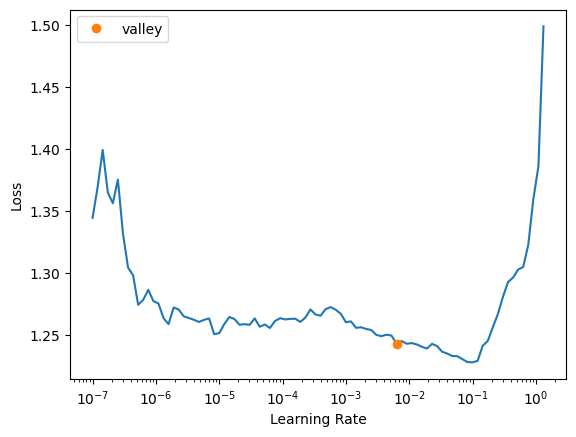

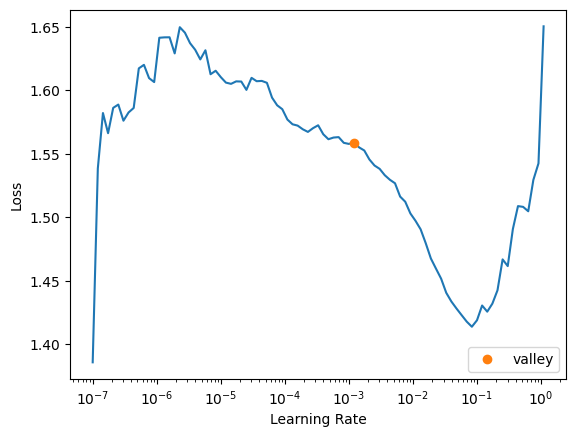

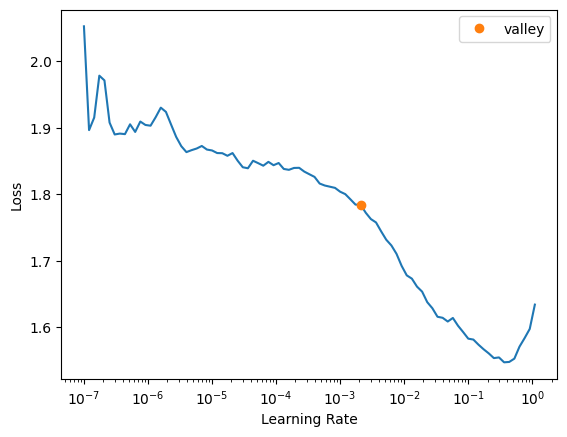

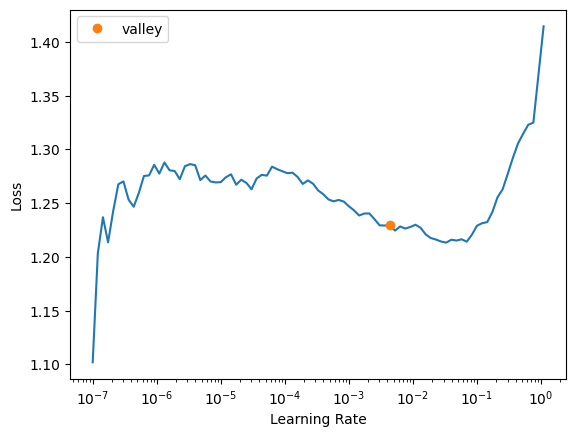

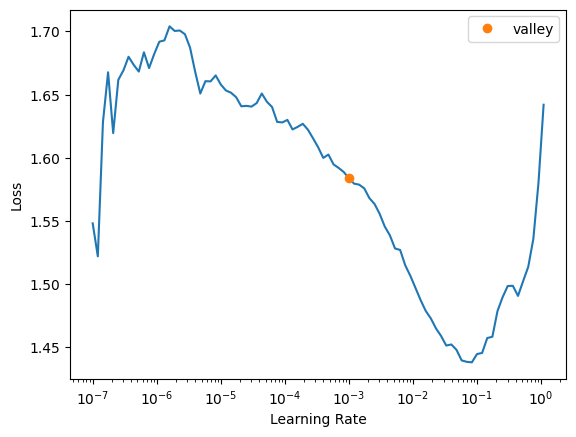

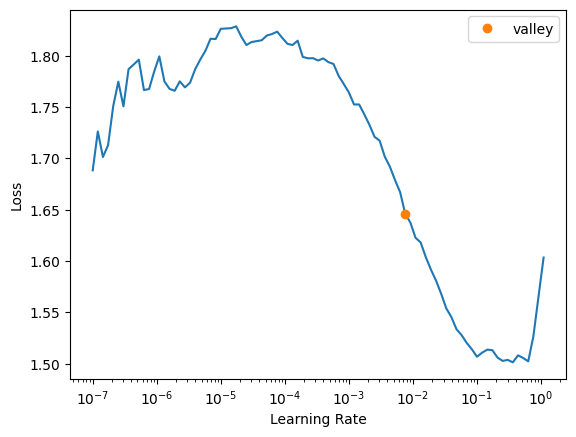

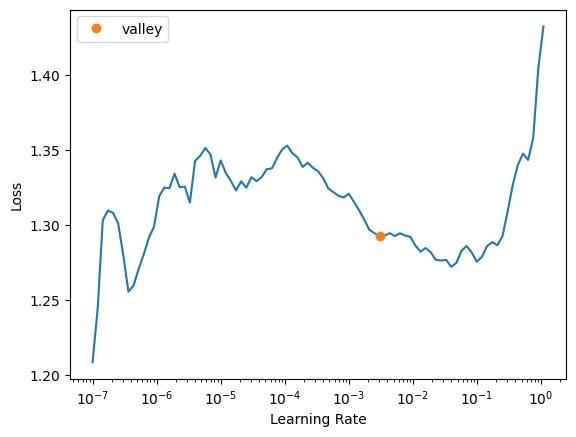

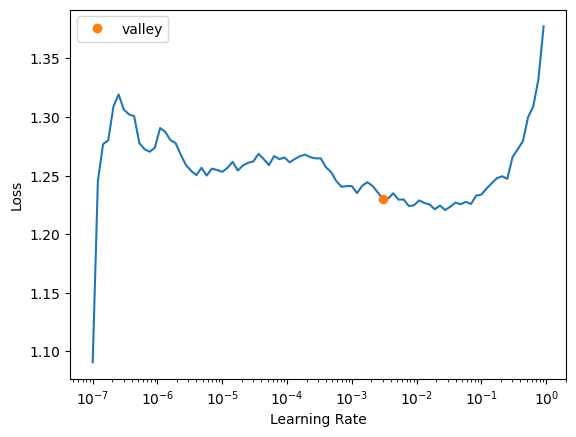

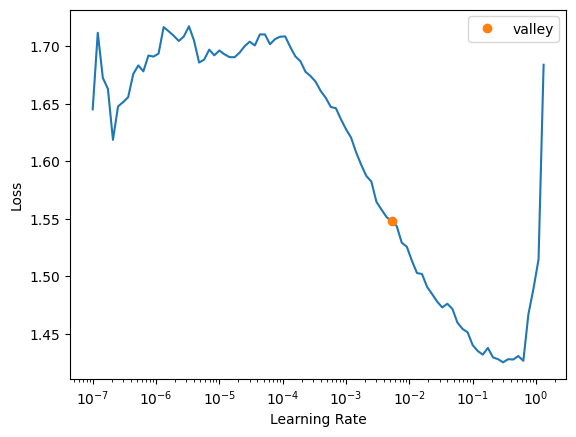

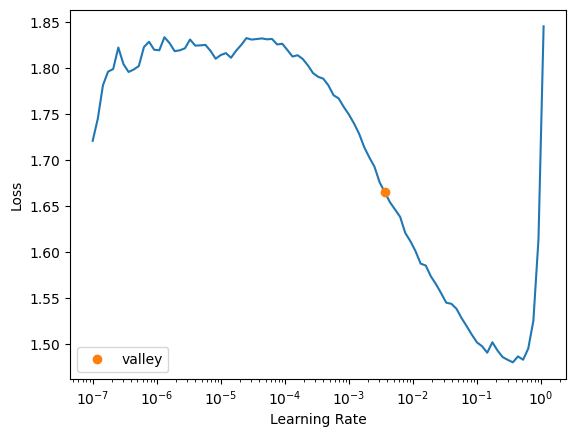

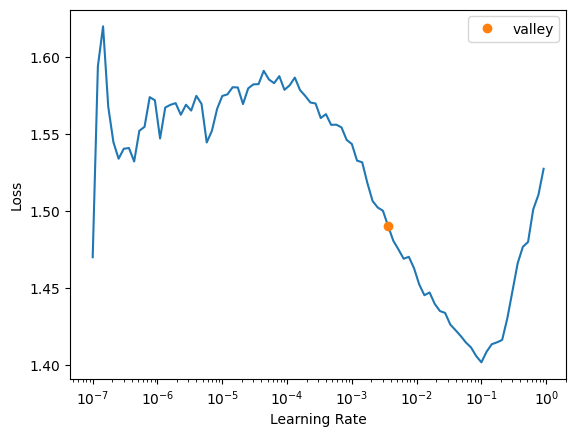

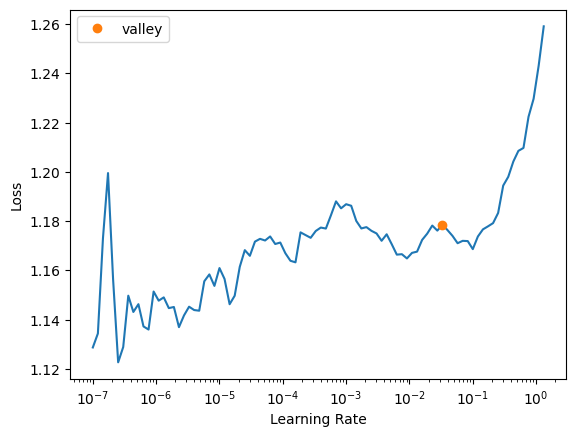

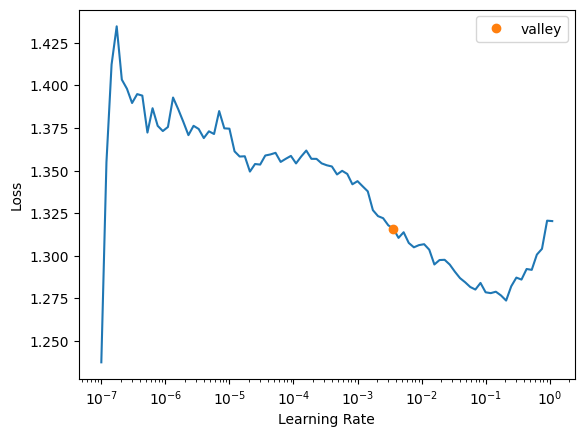

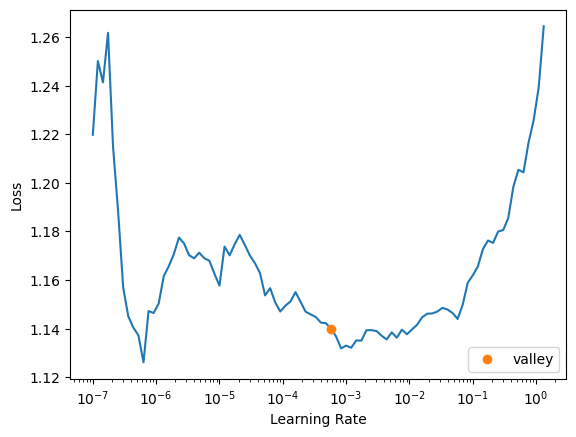

In [41]:
# SHADE-ILS-GD
results['SHADE-ILS-GD'] = {}
for layer in n_layers:
  start = time.perf_counter()
  results['SHADE-ILS-GD'][layer] = utilsTFG.SHADE_ILS_GD(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]),  max_evals, max_evals_shade, dls, mh_learners[layer], mh_learners[layer].model, max_ls=max_ls)
  end = time.perf_counter()
  time_mh['SHADE-ILS-GD'][layer] = end-start


In [42]:
#Validation error
fitness_valid['SHADE-ILS-GD'] = {}
for layer in n_layers:
  fitness_valid['SHADE-ILS-GD'][layer] = []
  for ind in results['SHADE-ILS-GD'][layer][3]:
    fitness_valid['SHADE-ILS-GD'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls))

In [43]:
#Compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE-ILS-GD for {layer} layers: {results['SHADE-ILS-GD'][layer][2]}")
  print(f"Validation error of SHADE-ILS-GD for {layer} layers: {fitness_valid['SHADE-ILS-GD'][layer]}")
  dif = np.array(fitness_valid['SHADE-ILS-GD'][layer]) - np.array(results['SHADE-ILS-GD'][layer][2])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE-ILS-GD'][layer])
  best['SHADE-ILS-GD'][layer] = results['SHADE-ILS-GD'][layer][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-ILS-GD for 1 layers: [2.6828105449676514, 1.2248330116271973, 1.2389205694198608, 1.2076566219329834, 1.1793292760849, 1.1469382047653198, 1.1422332525253296, 1.1422332525253296, 1.1422332525253296, 1.1422332525253296, 1.1422332525253296, 1.1422332525253296, 1.1422332525253296, 1.1422332525253296, 1.1422332525253296, 1.1422332525253296, 1.1422332525253296, 1.1422332525253296, 1.1422332525253296, 1.1422332525253296, 1.1422332525253296]
Validation error of SHADE-ILS-GD for 1 layers: [2.663362741470337, 1.670684814453125, 1.714306116104126, 3.8304896354675293, 3.6072709560394287, 3.981788158416748, 4.282137393951416, 4.282137393951416, 4.282137393951416, 4.282137393951416, 4.282137393951416, 4.282137393951416, 4.282137393951416, 4.282137393951416, 4.282137393951416, 4.282137393951416, 4.282137393951416, 4.282137393951416, 4.282137393951416, 4.282137393951416, 4.282137393951416]
Difference: [-0.0194478   0.4458518   0.47538555  2.62283301  2.42794168  2.83484995
  3

### Save or load

In [44]:
#Save the mh results
file_path = f'/notebooks/saved_models/mh_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results, f)

In [45]:
#Load the trained mh results
file_path = f'/notebooks/saved_models/mh_dict_{dataset}.pkl'
with open(file_path, 'rb') as f:
    results = pickle.load(f)

### Comparison between MH

In [46]:
#Saving training loss for better manipulation
training = {}
for mh in algs:
  training[mh] = {}
for layer in n_layers:
  training['SHADE'][layer] = results['SHADE'][layer][6]
  training['SHADE-ILS'][layer] = results['SHADE-ILS'][layer][2]
  training['SHADE-GD'][layer] = results['SHADE-GD'][layer][2]
  training['SHADE-ILS-GD'][layer] = results['SHADE-ILS-GD'][layer][2]

In [47]:
#Calculate accuracy and balanced accuracy
bal_acc = {}
for mh in algs:
  bal_acc[mh] = {}
  for layer in n_layers:
    bal_acc[mh][layer] = []
    ind = 5 if mh == 'SHADE' else 3
    for model in results[mh][layer][ind]:
      utilsTFG.set_params_to_model(model, mh_learners[layer].model)
      mh_learners[layer].model.eval()
      mh_learners[layer].eval()
      preds, targs = mh_learners[layer].get_preds(dl=dls.valid)
      targs = targs.long().squeeze()

      # Calculate balanced_accuracy
      bal_acc[mh][layer].append(utilsTFG.balanced_accuracy_func(preds, targs))

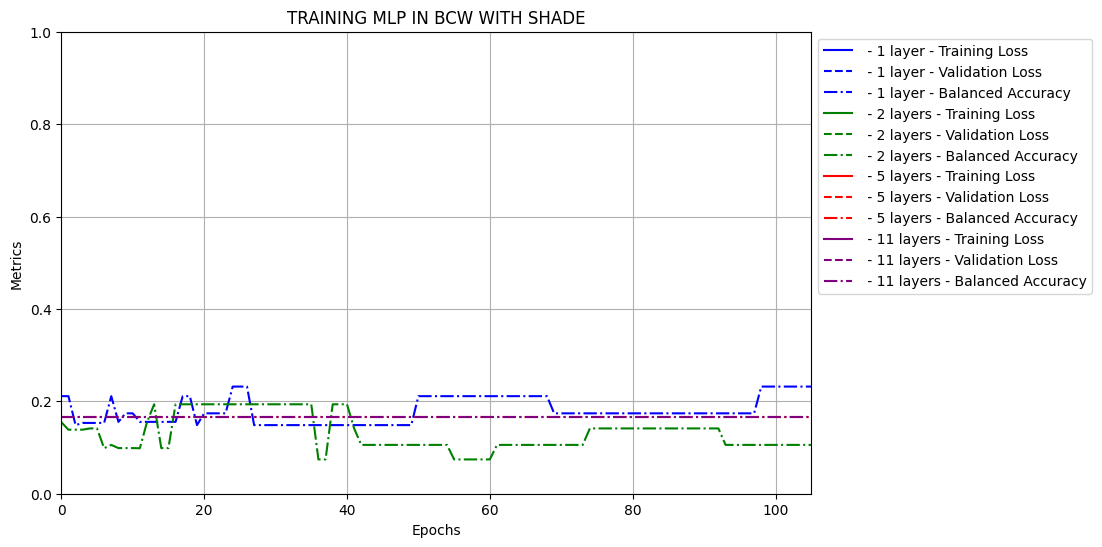

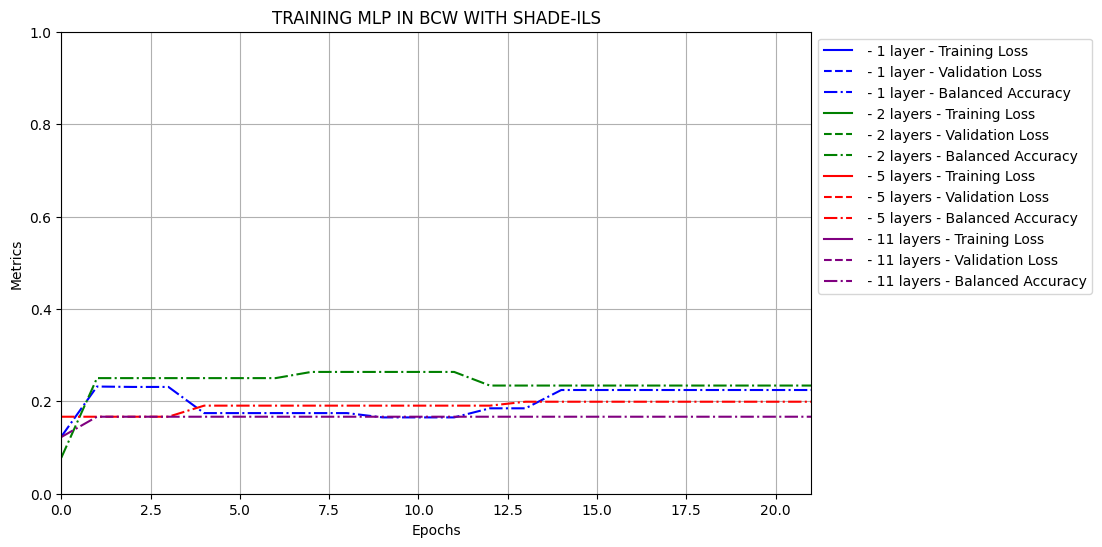

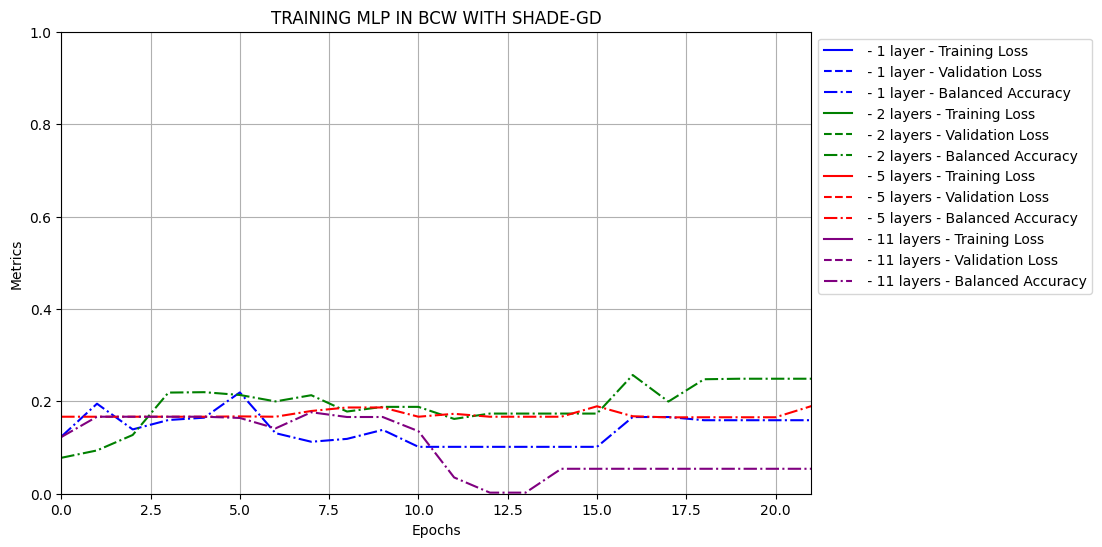

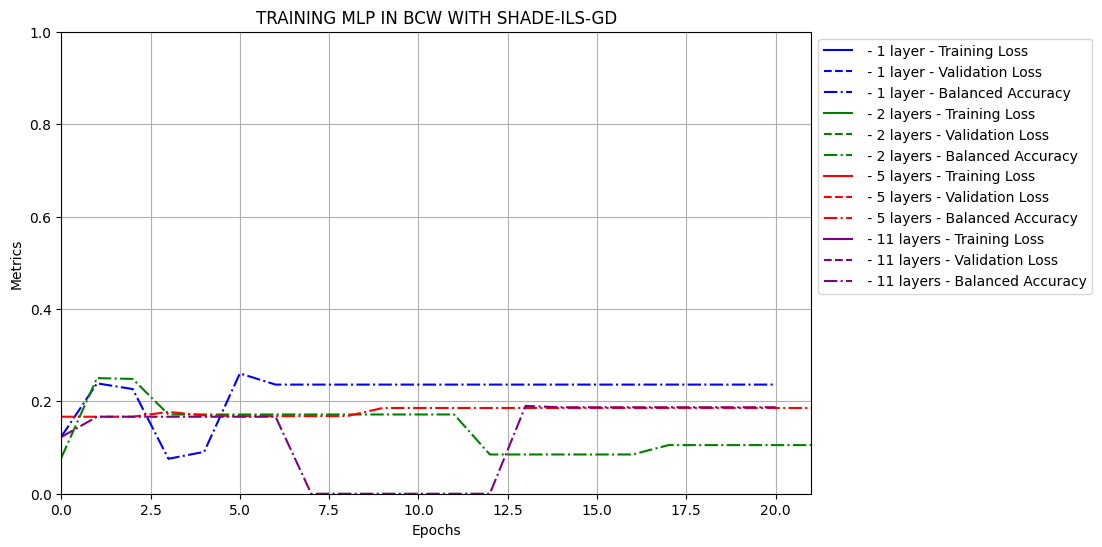

In [48]:
#Comparing the different layers version of the same MH
names= ['1 layer', '2 layers', '5 layers', '11 layers']
for alg in algs:
  utilsTFG.plot_mh_mlp_training(training[alg], fitness_valid[alg], bal_acc[alg],  layers = n_layers, names=names, title=f'TRAINING MLP IN BCW WITH {alg}')

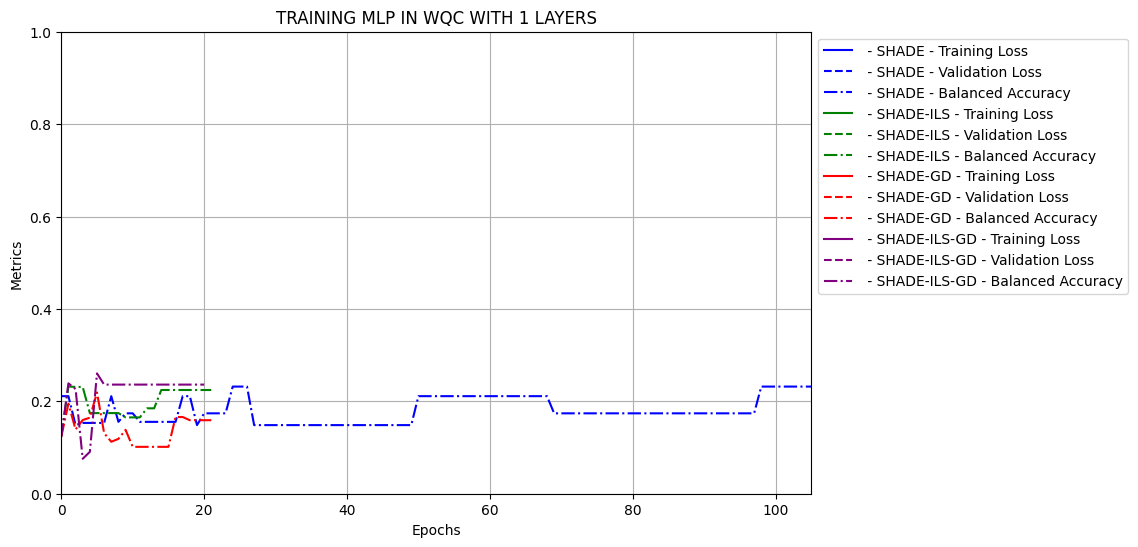

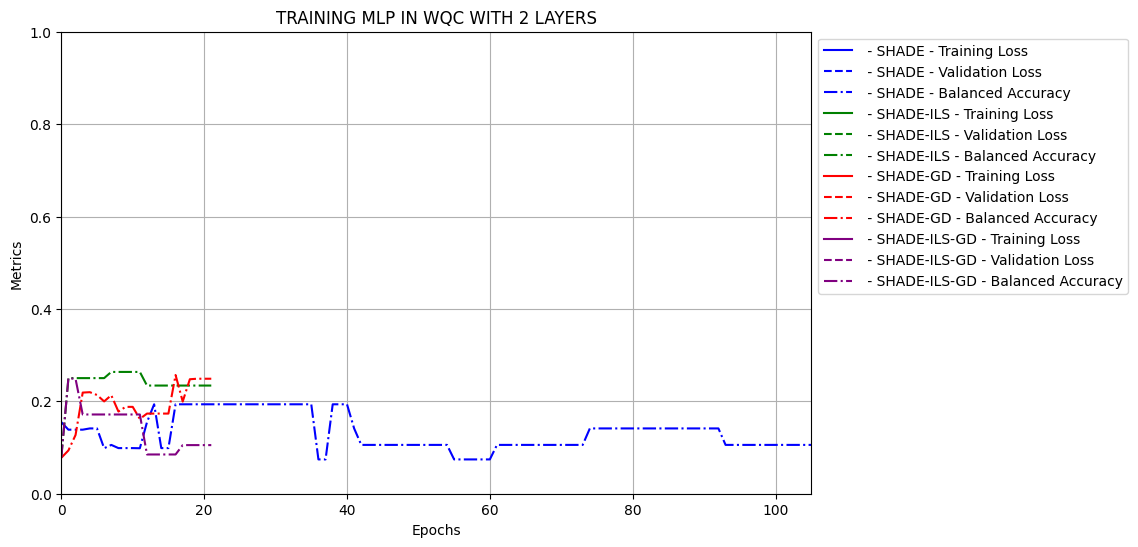

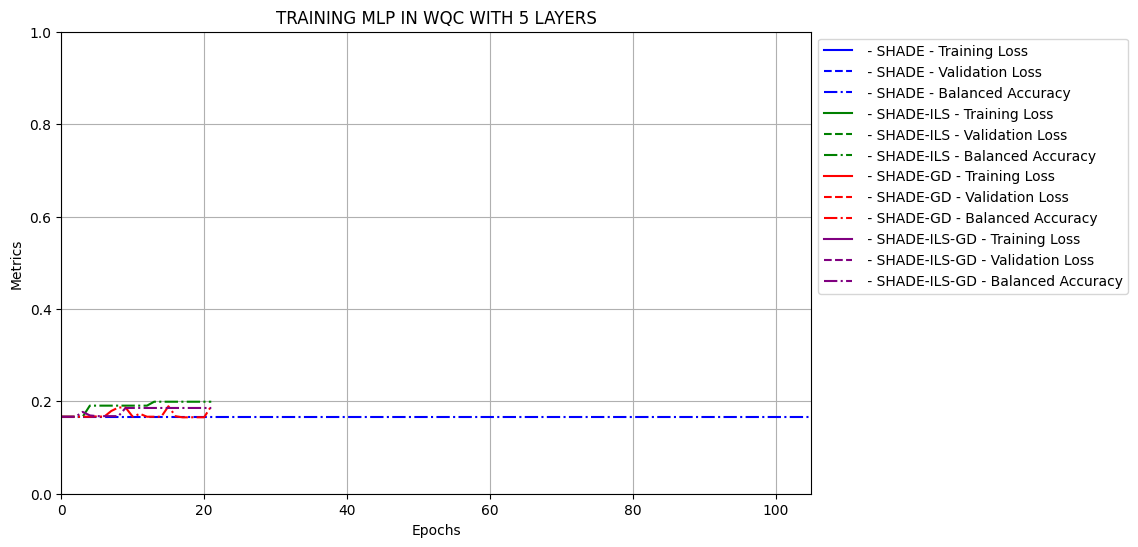

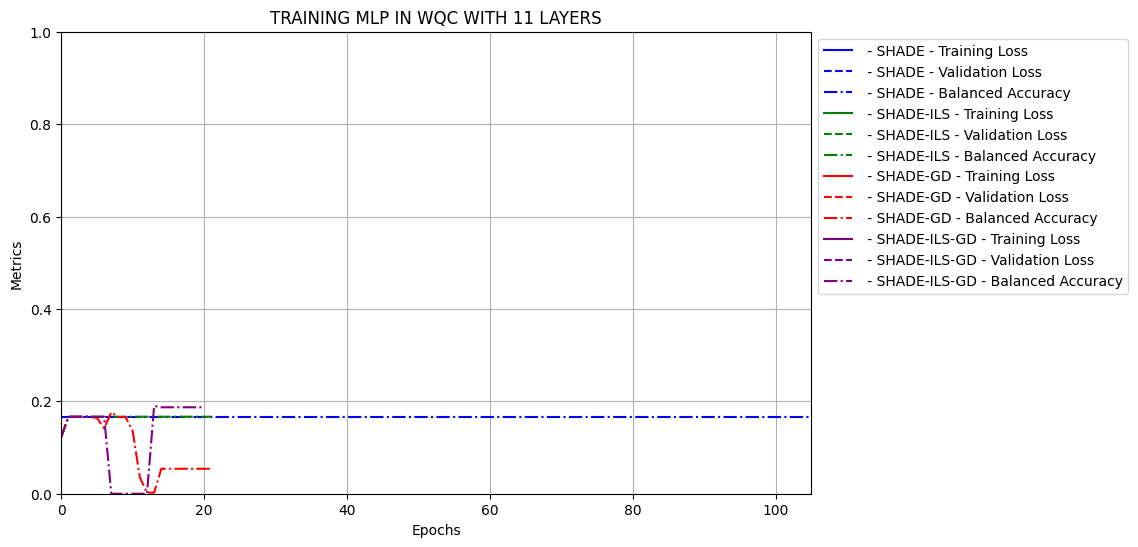

In [49]:
#Comparing the different MH for the same layer number

names= ['SHADE', 'SHADE-ILS', 'SHADE-GD', 'SHADE-ILS-GD']
train = {}
acc = {}
valid = {}
for layer in n_layers:
  train[layer] = {}
  acc[layer] = {}
  valid[layer] = {}
  for alg in algs:
    train[layer][alg] = training[alg][layer]
    acc[layer][alg] = bal_acc[alg][layer]
    valid[layer][alg] = fitness_valid[alg][layer]
  utilsTFG.plot_mh_mlp_training(train[layer], valid[layer], acc[layer], layers = names, names=names, title=f'TRAINING MLP IN {plot_dataset} WITH {layer} LAYERS')

### Generalization

In [50]:
#Run the model in the test set
for mh in algs:
  for layer in n_layers:
    #Run the model with optimizer optim and n_layers layer the test set in evaluation mode
    utilsTFG.set_params_to_model(best[mh][layer], mh_learners[layer].model)
    mh_learners[layer].model.eval()
    mh_learners[layer].eval()
    preds, targs = mh_learners[layer].get_preds(dl=test_dl)
    targs = targs.long().squeeze()

    #Calculate balanced accuracy

    ac = utilsTFG.balanced_accuracy_func(preds, targs)


    loss = utilsTFG.err_param_w_model(mh_learners[layer].model, test_dl, mode = 'test')

    print(f"Optimizer: {mh}, Layers: {layer}, Loss: {loss}, Balanced accuracy: {ac}")

Optimizer: SHADE, Layers: 1, Loss: 4.361486911773682, Balanced accuracy: 0.15459595450946007


Optimizer: SHADE, Layers: 2, Loss: 2.3086628913879395, Balanced accuracy: 0.19336533742943338


Optimizer: SHADE, Layers: 5, Loss: 2.3843441009521484, Balanced accuracy: 0.16666666666666666


Optimizer: SHADE, Layers: 11, Loss: 2.4083480834960938, Balanced accuracy: 0.16666666666666666


Optimizer: SHADE-ILS, Layers: 1, Loss: 1.7652548551559448, Balanced accuracy: 0.20560498171544117


Optimizer: SHADE-ILS, Layers: 2, Loss: 2.3504350185394287, Balanced accuracy: 0.19216959423817925


Optimizer: SHADE-ILS, Layers: 5, Loss: 1.2101693153381348, Balanced accuracy: 0.19207649762114098


Optimizer: SHADE-ILS, Layers: 11, Loss: 1.3350143432617188, Balanced accuracy: 0.16666666666666666


Optimizer: SHADE-GD, Layers: 1, Loss: 7.373187065124512, Balanced accuracy: 0.18193105179434654


Optimizer: SHADE-GD, Layers: 2, Loss: 2.7810842990875244, Balanced accuracy: 0.18082642697425888


Optimizer: SHADE-GD, Layers: 5, Loss: 1.2277017831802368, Balanced accuracy: 0.18874173011329978


Optimizer: SHADE-GD, Layers: 11, Loss: 971.581298828125, Balanced accuracy: 0.015747476915119487


Optimizer: SHADE-ILS-GD, Layers: 1, Loss: 1.8416913747787476, Balanced accuracy: 0.2055033807105924


Optimizer: SHADE-ILS-GD, Layers: 2, Loss: 2.0774214267730713, Balanced accuracy: 0.25032262685972345


Optimizer: SHADE-ILS-GD, Layers: 5, Loss: 1.2060319185256958, Balanced accuracy: 0.18927985733081418


Optimizer: SHADE-ILS-GD, Layers: 11, Loss: 1.356372356414795, Balanced accuracy: 0.16666666666666666


## Time comparison

In [51]:
#Compare times for each algorithm and layer

#GD
for alg, time_layers in time_mh.items():
  for layer, time in time_layers.items():
    print(f'Time consumed by {alg} training with {layer} layers: {time:.04f} seconds')

#MH
for optims, time_layers in time_gd.items():
  for layer, time in time_layers.items():
    print(f'Time consumed by {optims} training with {layer} layers: {time:.04f} seconds')



Time consumed by SHADE training with 1 layers: 675.1023 seconds
Time consumed by SHADE training with 2 layers: 727.9423 seconds
Time consumed by SHADE training with 5 layers: 919.7099 seconds
Time consumed by SHADE training with 11 layers: 1833.9624 seconds
Time consumed by SHADE-ILS training with 1 layers: 713.8030 seconds
Time consumed by SHADE-ILS training with 2 layers: 766.3179 seconds
Time consumed by SHADE-ILS training with 5 layers: 957.9978 seconds
Time consumed by SHADE-ILS training with 11 layers: 2020.7428 seconds
Time consumed by SHADE-GD training with 1 layers: 679.9567 seconds
Time consumed by SHADE-GD training with 2 layers: 725.0139 seconds
Time consumed by SHADE-GD training with 5 layers: 920.5430 seconds
Time consumed by SHADE-GD training with 11 layers: 1855.3864 seconds
Time consumed by SHADE-ILS-GD training with 1 layers: 683.1289 seconds
Time consumed by SHADE-ILS-GD training with 2 layers: 826.0711 seconds
Time consumed by SHADE-ILS-GD training with 5 layers: 12